In [1]:
groupvars = {}
with open("Group7_DB_Login.txt") as myfile:
    for line in myfile:
        name, var = line.partition(":")[::2]
        groupvars[name.strip()] = var.strip()

In [2]:
import MySQLdb
conn = MySQLdb.connect(host="localhost", user=groupvars['DB username'], 
                       passwd=groupvars['DB password'], db=groupvars['DB databasename'])
cursor = conn.cursor()

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly import subplots
from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  

## Q1. Number of Facilities in different states and Indiana cities

In [4]:
dfstpop = pd.read_sql_query("SELECT State, State_Abbr, Pop_2020 FROM `usstatepop_2020`where State not in ('United States') order by Pop_2020 DESC limit 5" , conn)
dfstpop = pd.DataFrame(dfstpop)
print(dfstpop.head())

          State State_Abbr  Pop_2020
0    California         CA  39538223
1         Texas         TX  29145505
2       Florida         FL  21538187
3      New York         NY  20201249
4  Pennsylvania         PA  13002700


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [5]:
dfctpop = pd.read_sql_query("SELECT CITY, STATE, CAST(POPEST2020 AS INT) as City_Pop FROM `city_pop_2020` order by CAST(POPEST2020 AS INT) DESC limit 5" , conn)
dfctpop = pd.DataFrame(dfctpop)
print(dfctpop.head())

           CITY         STATE  City_Pop
0    California    California  39499738
1         Texas         Texas  29217653
2       Florida       Florida  21569932
3      New York      New York  20154933
4  Pennsylvania  Pennsylvania  12989625


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [6]:
dfctpopin = pd.read_sql_query("SELECT CITY, CAST(POPEST2020 AS INT) FROM `city_pop_2020` where STATE = 'INDIANA' order by CAST(POPEST2020 AS INT) DESC limit 5" , conn)
dfctpopin = pd.DataFrame(dfctpopin)
print(dfctpopin.head())


            CITY  CAST(POPEST2020 AS INT)
0        Indiana                  6785644
1  Marion County                   976770
2   Indianapolis                   896749
3    Lake County                   498597
4   Allen County                   385892


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [7]:
#Inpatient Facilites by State

dfihp = pd.read_sql_query(" SELECT DISTINCT Prv_State, COUNT(*) AS TOTAL_IHP FROM Inpatient_2020_PrvSrv WHERE Prv_State not in ('Rndrng_Prvdr_State_Abrvtn') GROUP BY Prv_State  ORDER BY TOTAL_IHP DESC" , conn)
dfihp = pd.DataFrame(dfihp)
print(dfihp.head())

fig = go.Figure(data=go.Choropleth(
    locations=dfihp['Prv_State'], 
    z = dfihp['TOTAL_IHP'].astype(float), 
    locationmode = 'USA-states', 
    colorscale = 'Blues',
    colorbar_title = "Number of Facilities",
))

fig.update_layout(
    title_text = 'Inpatient Facilities in Different States',
    geo_scope='usa',
)

fig.show()

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



  Prv_State  TOTAL_IHP
0        CA      13146
1        FL      12813
2        TX      11436
3        NY       9119
4        PA       7667


In [8]:
#Inpatient Facilites by State normalized to population

dfihp = pd.read_sql_query("SELECT DISTINCT A.Prv_State, COUNT(A.Prv_State) AS TOTAL_IHP, B.Pop_2020 AS STATE_POP, (COUNT(A.Prv_State)/B.Pop_2020)*1000000 AS IHP_RATIO FROM Inpatient_2020_PrvSrv A JOIN usstatepop_2020 B ON A.Prv_State = B.State_Abbr WHERE Prv_State not in ('Rndrng_Prvdr_State_Abrvtn') GROUP BY Prv_State ORDER BY IHP_RATIO DESC" , conn)
dfihp = pd.DataFrame(dfihp)
print(dfihp.head())

fig = go.Figure(data=go.Choropleth(
    locations=dfihp['Prv_State'], 
    z = dfihp['IHP_RATIO'].astype(float), 
    locationmode = 'USA-states', 
    colorscale = 'Blues',
    colorbar_title = "FACILITES to STATE POPULATION RATIO * (10^6)",
))

fig.update_layout(
    title_text = 'Inpatient Facilities in Different States (Normalized with State Population data)',
    geo_scope='usa',
)

fig.show()

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



  Prv_State  TOTAL_IHP  STATE_POP  IHP_RATIO
0        DC        578     689545    838.233
1        WV       1460    1793716    813.952
2        MS       2209    2961279    745.961
3        ND        575     779094    738.036
4        SD        629     886667    709.398


In [10]:
#Outpatient Facilites by State

dfopd = pd.read_sql_query("SELECT PRV_STATE AS STATE, COUNT(*) AS TOTAL_OPD FROM Outpatient_2020_PrvSrv GROUP BY PRV_STATE ORDER BY TOTAL_OPD DESC" , conn)
dfopd  = pd.DataFrame(dfopd)
print(dfopd.head())

fig = go.Figure(data=go.Choropleth(
    locations=dfopd ['STATE'], 
    z = dfopd ['TOTAL_OPD'].astype(float), 
    locationmode = 'USA-states', 
    colorscale = 'Greens',
    colorbar_title = "Number of Facilities",
))

fig.update_layout(
    title_text = 'Outpatient Facilities in Different States',
    geo_scope='usa',
)

fig.show()

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



  STATE  TOTAL_OPD
0    CA      10441
1    TX       9797
2    FL       7096
3    PA       5479
4    NY       5379


In [11]:
#Outpatient Facilites by State normalized to population

dfopd = pd.read_sql_query("SELECT A.PRV_STATE AS STATE, COUNT(A.PRV_STATE) AS TOTAL_OPD, B.Pop_2020 AS STATE_POP, 
                          (COUNT(A.PRV_STATE)/B.Pop_2020)*1000000 AS OPD_RATIO FROM Outpatient_2020_PrvSrv A 
                          JOIN usstatepop_2020 B ON A.PRV_STATE = B.State_Abbr GROUP BY PRV_STATE 
                          ORDER BY OPD_RATIO DESC" , conn)
dfopd  = pd.DataFrame(dfopd)
print(dfopd.head())

fig = go.Figure(data=go.Choropleth(
    locations=dfopd ['STATE'], 
    z = dfopd ['OPD_RATIO'].astype(float), 
    locationmode = 'USA-states', 
    colorscale = 'Greens',
    colorbar_title = "FACILITES to STATE POPULATION RATIO * (10^6)",
))

fig.update_layout(
    title_text = 'Outpatient Facilities in Different States (Normalized with State Population data)',
    geo_scope='usa',
)

fig.show()

SyntaxError: unterminated string literal (detected at line 3) (2125311998.py, line 3)

In [19]:
#SNF Facilites by State

dfsnf = pd.read_sql_query(" SELECT STATE, COUNT(*) AS TOTAL_SNF FROM MD_PAC_SNF_2020 where STATE != 'NATIONAL TOTAL' GROUP BY STATE ORDER BY TOTAL_SNF DESC" , conn)
dfsnf = pd.DataFrame(dfsnf)
print(dfsnf.head())

fig = go.Figure(data=go.Choropleth(
    locations=dfsnf['STATE'], # Spatial coordinates
    z = dfsnf['TOTAL_SNF'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Number of Facilities",
))

fig.update_layout(
    title_text = 'Skilled Nursing Facilities in Different States',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

  STATE  TOTAL_SNF
0    TX       1192
1    CA       1082
2    OH        917
3    FL        704
4    PA        685


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [20]:
#SNF Facilites by State normalized to population

dfsnf = pd.read_sql_query("SELECT A.STATE, COUNT(A.STATE) AS TOTAL_SNF, B.Pop_2020 AS STATE_POP, (COUNT(A.STATE)/B.Pop_2020)*1000000 AS SNF_RATIO FROM MD_PAC_SNF_2020 A JOIN usstatepop_2020 B ON A.STATE = B.State_Abbr where A.STATE != 'NATIONAL TOTAL' GROUP BY A.STATE ORDER BY SNF_RATIO DESC" , conn)
dfsnf = pd.DataFrame(dfsnf)
print(dfsnf.head())

fig = go.Figure(data=go.Choropleth(
    locations=dfsnf['STATE'], 
    z = dfsnf['SNF_RATIO'].astype(float),
    locationmode = 'USA-states', 
    colorscale = 'Reds',
    colorbar_title = "FACILITES to STATE POPULATION RATIO * (10^6)",
))

fig.update_layout(
    title_text = 'Skilled Nursing Facilities in Different States (Normalized with State Population data)',
    geo_scope='usa', 
)

fig.show()

  STATE  TOTAL_SNF  STATE_POP  SNF_RATIO
0    IA        396    3190369    124.123
1    SD         96     886667    108.270
2    KS        271    2937880     92.243
3    NE        171    1961504     87.178
4    MO        494    6154913     80.261


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [21]:
#Hospice Facilites by State

dfhos = pd.read_sql_query("SELECT STATE, COUNT(*) AS TOTAL_HOSPICE FROM MD_PAC_HOS_2020 where STATE != 'NATIONAL TOTAL' GROUP BY STATE ORDER BY TOTAL_HOSPICE DESC" , conn)
dfhos = pd.DataFrame(dfhos)
print(dfhos.head())

import plotly.graph_objects as go

import pandas as pd

fig = go.Figure(data=go.Choropleth(
    locations=dfhos['STATE'], 
    z = dfhos['TOTAL_HOSPICE'].astype(float), 
    locationmode = 'USA-states', 
    colorscale = 'Greens',
    colorbar_title = "Number of Facilities",
))

fig.update_layout(
    title_text = 'Hospice Facilities in Different States',
    geo_scope='usa', 
)

fig.show()

  STATE  TOTAL_HOSPICE
0    CA           1020
1    TX            613
2    GA            203
3    PA            176
4    AZ            146


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [22]:
#Hospice Facilites by State normalized to population

dfhos = pd.read_sql_query("SELECT A.STATE, COUNT(A.STATE) AS TOTAL_HOSPICE, B.Pop_2020 AS STATE_POP, (COUNT(A.STATE)/B.Pop_2020)*1000000 AS HSP_RATIO FROM MD_PAC_HOS_2020 A JOIN usstatepop_2020 B ON A.STATE = B.State_Abbr where A.STATE != 'NATIONAL TOTAL' GROUP BY A.STATE ORDER BY HSP_RATIO DESC" , conn)
dfhos = pd.DataFrame(dfhos)
print(dfhos.head())

import plotly.graph_objects as go

import pandas as pd

fig = go.Figure(data=go.Choropleth(
    locations=dfhos['STATE'], 
    z = dfhos['HSP_RATIO'].astype(float), 
    locationmode = 'USA-states', 
    colorscale = 'Greens',
    colorbar_title = "FACILITES to STATE POPULATION RATIO * (10^6)",
))

fig.update_layout(
    title_text = 'Hospice Facilities in Different States (Normalized with State Population data)',
    geo_scope='usa', 
)

fig.show()

  STATE  TOTAL_HOSPICE  STATE_POP  HSP_RATIO
0    WY             18     576851     31.203
1    OK            116    3959353     29.297
2    MS             86    2961279     29.041
3    LA            122    4657757     26.192
4    ID             48    1839106     26.099


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [23]:
# Home Health Facilites by State normalized to population

dfhh = pd.read_sql_query("SELECT A.STATE, COUNT(A.STATE) AS TOTAL_HOMEHLTH, B.Pop_2020 AS STATE_POP, (COUNT(A.STATE)/B.Pop_2020)*1000000 AS HH_RATIO FROM pachh_2020v2 A JOIN usstatepop_2020 B ON A.STATE = B.State_Abbr where A.STATE != 'NATIONAL TOTAL' GROUP BY A.STATE ORDER BY HH_RATIO DESC" , conn)
dfhh = pd.DataFrame(dfhh)
print(dfhh.head())

import plotly.graph_objects as go

import pandas as pd

fig = go.Figure(data=go.Choropleth(
    locations=dfhh['STATE'], 
    z = dfhh['HH_RATIO'].astype(float), 
    locationmode = 'USA-states', 
    colorscale = 'Reds',
    colorbar_title = "FACILITES to STATE POPULATION RATIO * (10^6)",
))

fig.update_layout(
    title_text = 'Home Health Facilities in Different States (Normalized with State Population data)',
    geo_scope='usa', 
)

fig.show()

  STATE  TOTAL_HOMEHLTH  STATE_POP  HH_RATIO
0    OK             228    3959353    57.585
1    TX            1425   29145505    48.892
2    WY              28     576851    48.539
3    NV             139    3104614    44.772
4    IL             515   12812508    40.195


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [24]:
# Inpatient Rehab Facilites by State normalized to population

dfirf = pd.read_sql_query("SELECT A.STATE, COUNT(A.STATE) AS TOTAL_IRF, B.Pop_2020 AS STATE_POP, (COUNT(A.STATE)/B.Pop_2020)*1000000 AS IRF_RATIO FROM pacirf_2020v2 A JOIN usstatepop_2020 B ON A.STATE = B.State_Abbr where A.STATE != 'NATIONAL TOTAL' GROUP BY A.STATE ORDER BY IRF_RATIO DESC" , conn)
dfirf = pd.DataFrame(dfirf)
print(dfirf.head())

import plotly.graph_objects as go

import pandas as pd

fig = go.Figure(data=go.Choropleth(
    locations=dfirf['STATE'], 
    z = dfirf['IRF_RATIO'].astype(float), 
    locationmode = 'USA-states', 
    colorscale = 'Greens',
    colorbar_title = "FACILITES to STATE POPULATION RATIO * (10^6)",
))

fig.update_layout(
    title_text = 'Inpatient Rehab Facilities in Different States (Normalized with State Population data)',
    geo_scope='usa', 
)

fig.show()

  STATE  TOTAL_IRF  STATE_POP  IRF_RATIO
0    LA         50    4657757     10.734
1    AR         27    3011524      8.965
2    KS         21    2937880      7.148
3    ND          5     779094      6.417
4    OK         24    3959353      6.061


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [25]:
# Longterm Care Facilites by State

dfltc = pd.read_sql_query("SELECT A.STATE, COUNT(A.STATE) AS TOTAL_LTC, B.Pop_2020 AS STATE_POP, (COUNT(A.STATE)/B.Pop_2020)*1000000 AS LTC_RATIO FROM pacltc_2020v2 A JOIN usstatepop_2020 B ON A.STATE = B.State_Abbr where A.STATE != 'NATIONAL TOTAL' GROUP BY A.STATE ORDER BY LTC_RATIO DESC" , conn)
dfltc = pd.DataFrame(dfltc)
print(dfltc.head())

import plotly.graph_objects as go

import pandas as pd

fig = go.Figure(data=go.Choropleth(
    locations=dfltc['STATE'], 
    z = dfltc['LTC_RATIO'].astype(float), 
    locationmode = 'USA-states', 
    colorscale = 'Blues',
    colorbar_title = "FACILITES to STATE POPULATION RATIO * (10^6)",
))

fig.update_layout(
    title_text = 'Longterm Care Facilities in Different States (Normalized with State Population data)',
    geo_scope='usa', 
)

fig.show()

  STATE  TOTAL_LTC  STATE_POP  LTC_RATIO
0    LA         27    4657757      5.796
1    DC          3     689545      4.350
2    ND          3     779094      3.850
3    AR          9    3011524      2.988
4    WV          5    1793716      2.787


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



### Indiana State Level Facilities Distribution

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



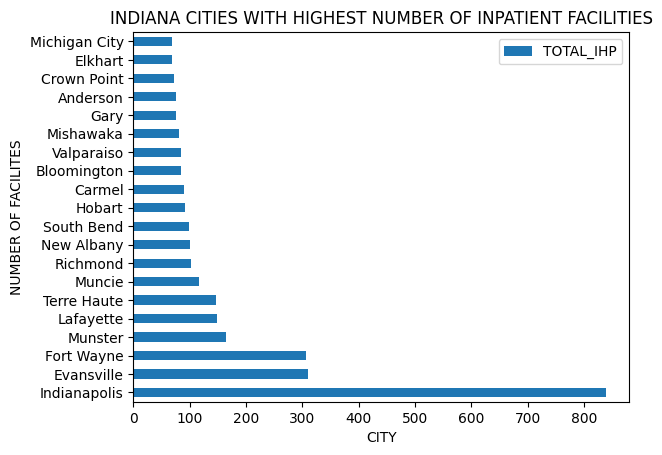

In [26]:
#Inpatient Facilites In Indiana State

dfihp_ct = pd.read_sql_query(" SELECT DISTINCT Prv_City, COUNT(*) AS TOTAL_IHP FROM Inpatient_2020_PrvSrv WHERE Prv_State in ('IN') GROUP BY Prv_City ORDER BY TOTAL_IHP DESC limit 20" , conn)
dfihp_ct = pd.DataFrame(dfihp_ct)

dfihp_ct.plot.barh('Prv_City','TOTAL_IHP')
plt.xlabel('CITY')
plt.ylabel('NUMBER OF FACILITES')
plt.title('INDIANA CITIES WITH HIGHEST NUMBER OF INPATIENT FACILITIES')
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



           CITY  TOTAL_IHP  CITY_POP  IHP_CITY_RATIO
0       Munster        165     23895         69.0521
1  Lawrenceburg         30      5102         58.8005
2      Danville         41     10594         38.7012
3     Vincennes         54     16776         32.1888
4        Hobart         92     29669         31.0088


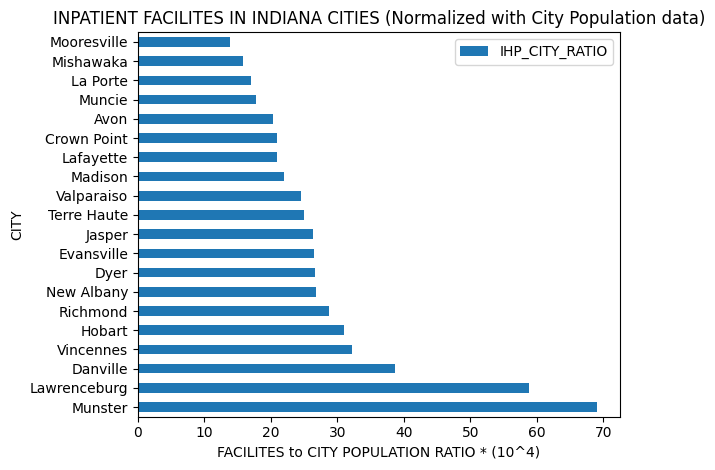

In [27]:
#Inpatient Facilites In Indiana State normalized to population

dfihp_ct = pd.read_sql_query("SELECT DISTINCT A.Prv_City as CITY, COUNT(A.Prv_City) AS TOTAL_IHP, B.POPEST2020 AS CITY_POP, (COUNT(A.Prv_City)/B.POPEST2020)*10000 AS IHP_CITY_RATIO FROM Inpatient_2020_PrvSrv A JOIN city_pop_2020 B ON A.Prv_State = B.STATE_ABBR AND A.Prv_City = B.CITY WHERE A.Prv_State in ('IN') AND A.Prv_City = B.CITY GROUP BY A.Prv_City ORDER BY IHP_CITY_RATIO DESC limit 20" , conn)
dfihp_ct = pd.DataFrame(dfihp_ct)
print(dfihp_ct.head())

dfihp_ct.plot.barh('CITY','IHP_CITY_RATIO')
plt.xlabel('FACILITES to CITY POPULATION RATIO * (10^4)')
plt.ylabel('CITY')
plt.yticks(fontsize = 10)
plt.title('INPATIENT FACILITES IN INDIANA CITIES (Normalized with City Population data)')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



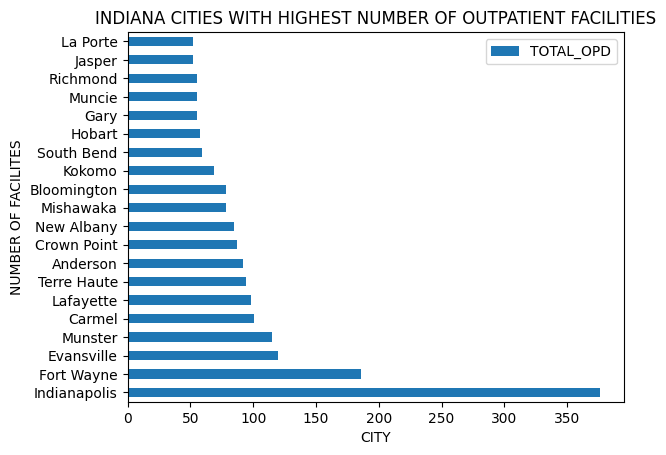

In [64]:
#Outpatient Facilites In Indiana State 

dfopd_ct = pd.read_sql_query(" SELECT PRV_City, COUNT(*) AS TOTAL_OPD FROM Outpatient_2020_PrvSrv WHERE Prv_State in ('IN') GROUP BY PRV_City ORDER BY TOTAL_OPD DESC limit 20" , conn)
dfopd_ct = pd.DataFrame(dfopd_ct)

dfopd_ct.plot.barh('PRV_City','TOTAL_OPD')
plt.xlabel('CITY')
plt.ylabel('NUMBER OF FACILITES')
plt.title('INDIANA CITIES WITH HIGHEST NUMBER OF OUTPATIENT FACILITIES')
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



           CITY  TOTAL_OPD  CITY_POP  OPD_CITY_RATIO
0  Lawrenceburg         36      5102         70.5606
1      Newburgh         17      3358         50.6254
2       Munster        115     23895         48.1272
3          Knox         15      3587         41.8177
4      Danville         42     10594         39.6451


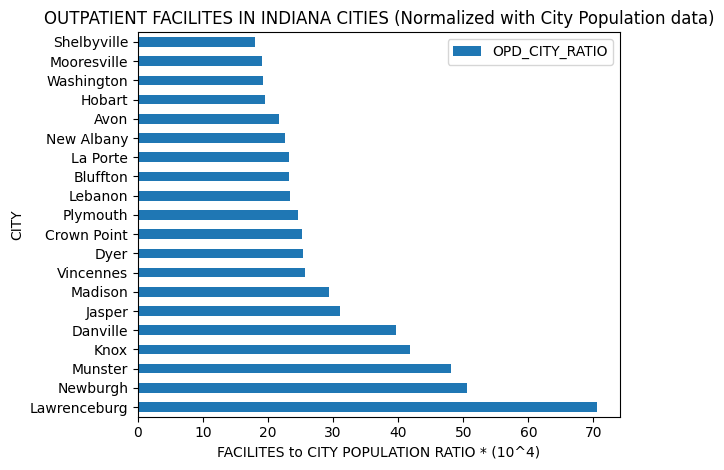

In [30]:
#Outpatient Facilites In Indiana State normalized to population

dfopd_ct = pd.read_sql_query("SELECT A.Prv_City as CITY, COUNT(A.Prv_City) AS TOTAL_OPD, B.POPEST2020 AS CITY_POP, (COUNT(A.Prv_City)/B.POPEST2020)*10000 AS OPD_CITY_RATIO FROM Outpatient_2020_PrvSrv A JOIN city_pop_2020 B ON A.Prv_State = B.STATE_ABBR AND A.Prv_City = B.CITY WHERE A.Prv_State in ('IN') AND A.Prv_City = B.CITY GROUP BY A.Prv_City ORDER BY OPD_CITY_RATIO DESC limit 20" , conn)
dfopd_ct = pd.DataFrame(dfopd_ct)
print(dfopd_ct.head())

dfopd_ct.plot.barh('CITY','OPD_CITY_RATIO')
plt.xlabel('FACILITES to CITY POPULATION RATIO * (10^4)')
plt.ylabel('CITY')
plt.yticks(fontsize = 10)
plt.title('OUTPATIENT FACILITES IN INDIANA CITIES (Normalized with City Population data)')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



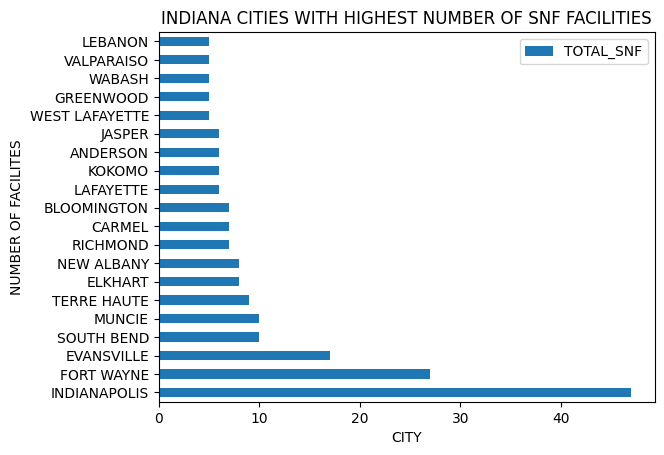

In [31]:
#SNF Facilites In Indiana State 

snf_ct = pd.read_sql_query(" SELECT PRVDR_CITY, COUNT(*) AS TOTAL_SNF FROM MD_PAC_SNF_2020 where STATE = 'IN' GROUP BY PRVDR_CITY ORDER BY TOTAL_SNF DESC limit 20" , conn)
snf_ct = pd.DataFrame(snf_ct)
snf_ct.head()

snf_ct.plot.barh('PRVDR_CITY','TOTAL_SNF')
plt.xlabel('CITY')
plt.ylabel('NUMBER OF FACILITES')
plt.title('INDIANA CITIES WITH HIGHEST NUMBER OF SNF FACILITIES')
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



           CITY  TOTAL_OPD  CITY_POP  SNF_CITY_RATIO
0   LEAVENWORTH          1       264         37.8788
1       OAKTOWN          1       579         17.2712
2      NEWBURGH          5      3358         14.8898
3   NEW HARMONY          1       686         14.5773
4  KNIGHTSVILLE          1       689         14.5138


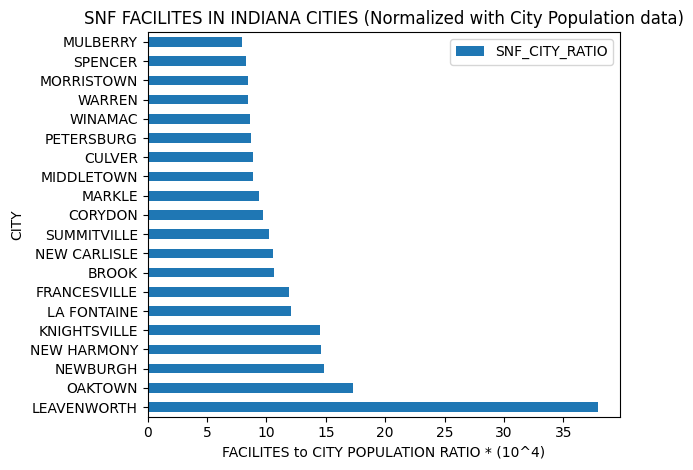

In [32]:
#SNF Facilites In Indiana State normalized to population

snf_ct = pd.read_sql_query("SELECT A.PRVDR_CITY as CITY, COUNT(A.PRVDR_CITY) AS TOTAL_OPD, B.POPEST2020 AS CITY_POP, (COUNT(A.PRVDR_CITY)/B.POPEST2020)*10000 AS SNF_CITY_RATIO FROM MD_PAC_SNF_2020 A JOIN city_pop_2020 B ON A.STATE = B.STATE_ABBR AND A.PRVDR_CITY = B.CITY where A.STATE = 'IN' AND A.PRVDR_CITY = B.CITY AND A.STATE = B.STATE_ABBR GROUP BY A.PRVDR_CITY ORDER BY SNF_CITY_RATIO DESC limit 20" , conn)
snf_ct = pd.DataFrame(snf_ct)
print(snf_ct.head())

snf_ct.plot.barh('CITY','SNF_CITY_RATIO')
plt.xlabel('FACILITES to CITY POPULATION RATIO * (10^4)')
plt.ylabel('CITY')
plt.yticks(fontsize = 10)
plt.title('SNF FACILITES IN INDIANA CITIES (Normalized with City Population data)')
plt.tight_layout()
plt.show()



/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



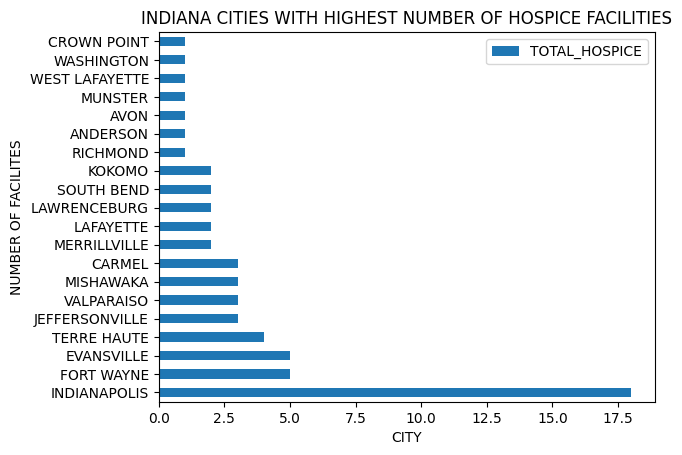

In [33]:
#Hospice Facilites In Indiana State

hos_ct = pd.read_sql_query(" SELECT PRVDR_CITY, COUNT(*) AS TOTAL_HOSPICE FROM MD_PAC_HOS_2020 where STATE = 'IN' GROUP BY PRVDR_CITY ORDER BY TOTAL_HOSPICE DESC LIMIT 20" , conn)
hos_ct = pd.DataFrame(hos_ct)
hos_ct.head()

hos_ct.plot.barh('PRVDR_CITY','TOTAL_HOSPICE')
plt.xlabel('CITY')
plt.ylabel('NUMBER OF FACILITES')
plt.title('INDIANA CITIES WITH HIGHEST NUMBER OF HOSPICE FACILITIES')
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



           CITY  TOTAL_HOSPICE  CITY_POP  HSP_CITY_RATIO
0  LAWRENCEBURG              2      5102          3.9200
1      MITCHELL              1      3930          2.5445
2         BERNE              1      4141          2.4149
3     ROCHESTER              1      6280          1.5924
4      PORTLAND              1      6292          1.5893


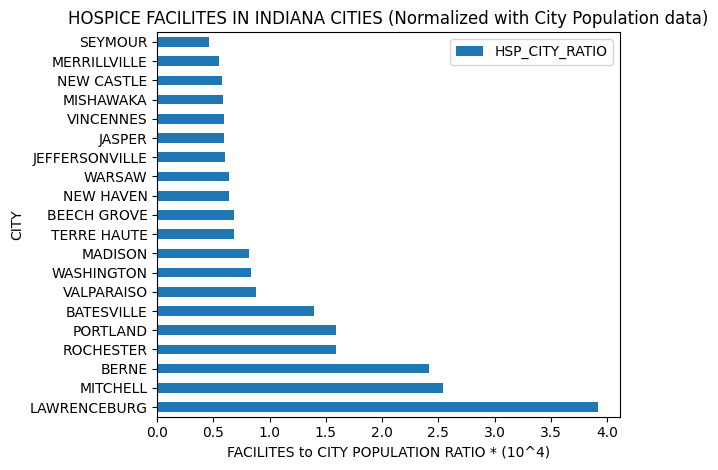

In [34]:
#Hospice Facilites In Indiana State normalized to population

hos_ct = pd.read_sql_query("SELECT A.PRVDR_CITY as CITY, COUNT(A.PRVDR_CITY) AS TOTAL_HOSPICE, B.POPEST2020 AS CITY_POP, (COUNT(A.PRVDR_CITY)/B.POPEST2020)*10000 AS HSP_CITY_RATIO FROM MD_PAC_HOS_2020 A JOIN city_pop_2020 B ON A.STATE = B.STATE_ABBR AND A.PRVDR_CITY = B.CITY AND A.STATE = B.STATE_ABBR where A.STATE = 'IN' AND A.PRVDR_CITY = B.CITY AND A.STATE = B.STATE_ABBR GROUP BY A.PRVDR_CITY ORDER BY HSP_CITY_RATIO DESC LIMIT 20" , conn)
hos_ct = pd.DataFrame(hos_ct)
print(hos_ct.head())

hos_ct.plot.barh('CITY','HSP_CITY_RATIO')
plt.ylabel('CITY')
plt.xlabel('FACILITES to CITY POPULATION RATIO * (10^4)')
plt.yticks(fontsize = 10)
plt.title('HOSPICE FACILITES IN INDIANA CITIES (Normalized with City Population data)')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



           CITY  TOTAL_HOMEHLTH  CITY_POP  HH_CITY_RATIO
0      HIGHLAND              11     23847         4.6127
1  LAWRENCEBURG               2      5102         3.9200
2    BROOKVILLE               1      2620         3.8168
3  MERRILLVILLE              13     36591         3.5528
4      BICKNELL               1      3019         3.3124


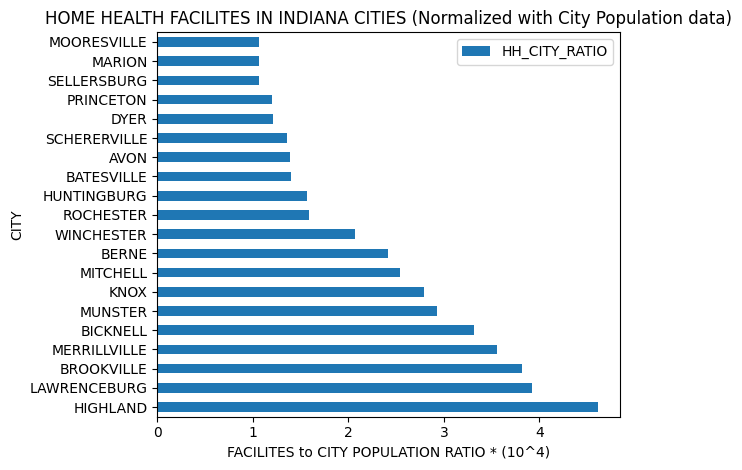

In [35]:
#Home Health Facilites In Indiana State normalized to population

hh_ct = pd.read_sql_query("SELECT A.PRVDR_CITY as CITY, COUNT(A.PRVDR_CITY) AS TOTAL_HOMEHLTH, B.POPEST2020 AS CITY_POP, (COUNT(A.PRVDR_CITY)/B.POPEST2020)*10000 AS HH_CITY_RATIO FROM pachh_2020v2 A JOIN city_pop_2020 B ON A.STATE = B.STATE_ABBR AND A.PRVDR_CITY = B.CITY AND A.STATE = B.STATE_ABBR where A.STATE = 'IN' AND A.PRVDR_CITY = B.CITY AND A.STATE = B.STATE_ABBR GROUP BY A.PRVDR_CITY ORDER BY HH_CITY_RATIO DESC LIMIT 20" , conn)
hh_ct = pd.DataFrame(hh_ct)
print(hh_ct.head())

hh_ct.plot.barh('CITY','HH_CITY_RATIO')
plt.ylabel('CITY')
plt.xlabel('FACILITES to CITY POPULATION RATIO * (10^4)')
plt.yticks(fontsize = 10)
plt.title('HOME HEALTH FACILITES IN INDIANA CITIES (Normalized with City Population data)')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



         CITY  TOTAL_IRF  CITY_POP  IRF_CITY_RATIO
0    NEWBURGH          1      3358          2.9780
1  WASHINGTON          1     11990          0.8340
2        DYER          1     16532          0.6049
3      JASPER          1     16727          0.5978
4   VINCENNES          1     16776          0.5961


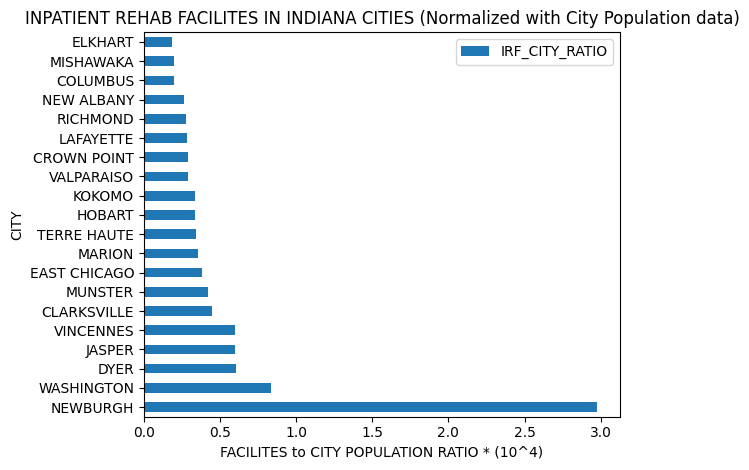

In [36]:
#IRF Facilites In Indiana State normalized to population

irf_ct = pd.read_sql_query("SELECT A.PRVDR_CITY as CITY, COUNT(A.PRVDR_CITY) AS TOTAL_IRF, B.POPEST2020 AS CITY_POP, (COUNT(A.PRVDR_CITY)/B.POPEST2020)*10000 AS IRF_CITY_RATIO FROM pacirf_2020v2 A JOIN city_pop_2020 B ON A.STATE = B.STATE_ABBR AND A.PRVDR_CITY = B.CITY AND A.STATE = B.STATE_ABBR where A.STATE = 'IN' AND A.PRVDR_CITY = B.CITY AND A.STATE = B.STATE_ABBR GROUP BY A.PRVDR_CITY ORDER BY IRF_CITY_RATIO DESC LIMIT 20" , conn)
irf_ct = pd.DataFrame(irf_ct)
print(irf_ct.head())

irf_ct.plot.barh('CITY','IRF_CITY_RATIO')
plt.ylabel('CITY')
plt.xlabel('FACILITES to CITY POPULATION RATIO * (10^4)')
plt.yticks(fontsize = 10)
plt.title('INPATIENT REHAB FACILITES IN INDIANA CITIES (Normalized with City Population data)')
plt.tight_layout()
plt.show()

           CITY  TOTAL_LTC  CITY_POP  LTC_CITY_RATIO
0  EAST CHICAGO          1     26258          0.3808
1   CROWN POINT          1     34511          0.2898
2        MUNCIE          1     65241          0.1533
3       HAMMOND          1     77607          0.1289
4    EVANSVILLE          1    117258          0.0853


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



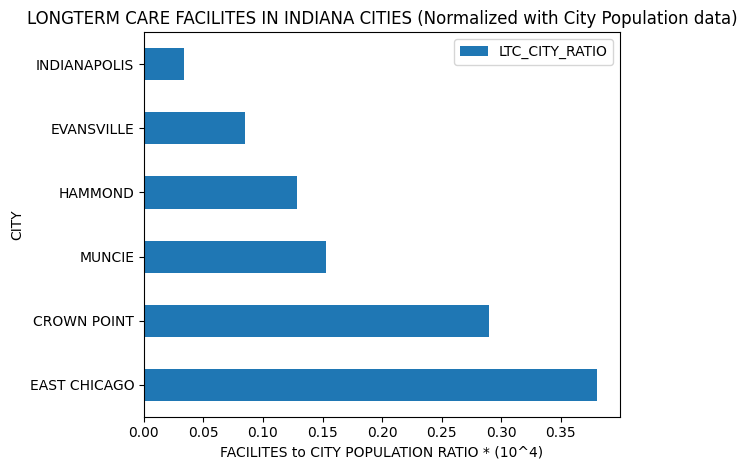

In [37]:
# Longterm Care Facilites In Indiana State normalized to population

ltc_ct = pd.read_sql_query("SELECT A.PRVDR_CITY as CITY, COUNT(A.PRVDR_CITY) AS TOTAL_LTC, B.POPEST2020 AS CITY_POP, (COUNT(A.PRVDR_CITY)/B.POPEST2020)*10000 AS LTC_CITY_RATIO FROM pacltc_2020v2 A JOIN city_pop_2020 B ON A.STATE = B.STATE_ABBR AND A.PRVDR_CITY = B.CITY AND A.STATE = B.STATE_ABBR where A.STATE = 'IN' AND A.PRVDR_CITY = B.CITY AND A.STATE = B.STATE_ABBR GROUP BY A.PRVDR_CITY ORDER BY LTC_CITY_RATIO DESC LIMIT 20" , conn)
ltc_ct = pd.DataFrame(ltc_ct)
print(ltc_ct.head())

ltc_ct.plot.barh('CITY','LTC_CITY_RATIO')
plt.ylabel('CITY')
plt.xlabel('FACILITES to CITY POPULATION RATIO * (10^4)')
plt.yticks(fontsize = 10)
plt.title('LONGTERM CARE FACILITES IN INDIANA CITIES (Normalized with City Population data)')
plt.tight_layout()
plt.show()

### Q2. TOP INDICATIONS BASED ON PATIENT COUNTS FOR INPATIENT AND OUTPATIENT SERVICES

In [38]:
# TOP 10 DISEASES AND STATES FOR INPATIENT CONDITIONS

dfihptp = pd.read_sql_query("SELECT DISTINCT A.DRG_CD, A.DRG_DESC, SUM(A.TOT_DSCHRGS) AS TOT_DSCH_DIS_20 FROM Inpatient_2020_PrvSrv A GROUP BY A.DRG_CD, A.DRG_DESC ORDER BY SUM(A.TOT_DSCHRGS) DESC LIMIT 10" , conn)
dfihptp = pd.DataFrame(dfihptp)
print(dfihptp.head())

dfihptp = pd.read_sql_query("SELECT DISTINCT A.Prv_City, SUM(A.TOT_DSCHRGS) AS TOT_DSCH_ST_20 FROM Inpatient_2020_PrvSrv A GROUP BY A.Prv_City ORDER BY SUM(A.TOT_DSCHRGS) DESC LIMIT 10" , conn)
dfihptp = pd.DataFrame(dfihptp)
print(dfihptp.head())

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



   DRG_CD                                           DRG_DESC  TOT_DSCH_DIS_20
0     871  SEPTICEMIA OR SEVERE SEPSIS W/O MV >96 HOURS W...         586558.0
1     291                   HEART FAILURE AND SHOCK WITH MCC         329977.0
2     470  MAJOR HIP AND KNEE JOINT REPLACEMENT OR REATTA...         268571.0
3     177  RESPIRATORY INFECTIONS AND INFLAMMATIONS WITH MCC         179339.0
4     193             SIMPLE PNEUMONIA AND PLEURISY WITH MCC         128737.0
      Prv_City  TOT_DSCH_ST_20
0     New York         75638.0
1    Baltimore         50864.0
2      Houston         46163.0
3       Boston         46147.0
4  Springfield         44568.0


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [39]:
ihp_pt1 = pd.read_sql_query("SELECT DRG_CD, DRG_DESC, TOT_DSCH_18 from IHP_TOPDISCH_DISEASE_18 order by DRG_CD" , conn)
ihp_pt1 = pd.DataFrame(ihp_pt1)
#print(ihp_pt1)
ihp_pt2 = pd.read_sql_query("SELECT DRG_CD,TOT_DSCH_19 from IHP_TOPDISCH_DISEASE_19 order by DRG_CD" , conn)
ihp_pt2 = pd.DataFrame(ihp_pt2)
#print(ihp_pt2)
ihp_pt3 = pd.read_sql_query("SELECT DRG_CD,TOT_DSCH_20 from IHP_TOPDISCH_DISEASE_20 order by DRG_CD" , conn)
ihp_pt3 = pd.DataFrame(ihp_pt3)
#print(ihp_pt3)
ihp_pt = pd.concat([ihp_pt1, ihp_pt2['TOT_DSCH_19'] , ihp_pt3['TOT_DSCH_20']], axis=1)
ihp_pt


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



DRG_CD                                           DRG_DESC  TOT_DSCH_18  \
0     177       RESPIRATORY INFECTIONS & INFLAMMATIONS W MCC      73413.0   
1     189              PULMONARY EDEMA & RESPIRATORY FAILURE     147918.0   
2     193                  SIMPLE PNEUMONIA & PLEURISY W MCC     164685.0   
3     291                        HEART FAILURE & SHOCK W MCC     381898.0   
4     378                               G.I. HEMORRHAGE W CC     128431.0   
5     392  "ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDER...     141917.0   
6     470  MAJOR HIP AND KNEE JOINT REPLACEMENT OR REATTA...     463050.0   
7     690          KIDNEY & URINARY TRACT INFECTIONS W/O MCC     128310.0   
8     871  SEPTICEMIA OR SEVERE SEPSIS W/O MV >96 HOURS W...     625930.0   
9     872  SEPTICEMIA OR SEVERE SEPSIS W/O MV >96 HOURS W...     159380.0   

   TOT_DSCH_19  TOT_DSCH_20  
0      72024.0     358678.0  
1     142779.0     213582.0  
2     147397.0     257474.0  
3     393492.0     659954.0  
4     122839.0     207508.0  
5     133569.0     204170.0  
6     420838.0     537142.0  
7     126130.0     190072.0  
8     607114.0    1173116.0  
9     153356.0     251570.0

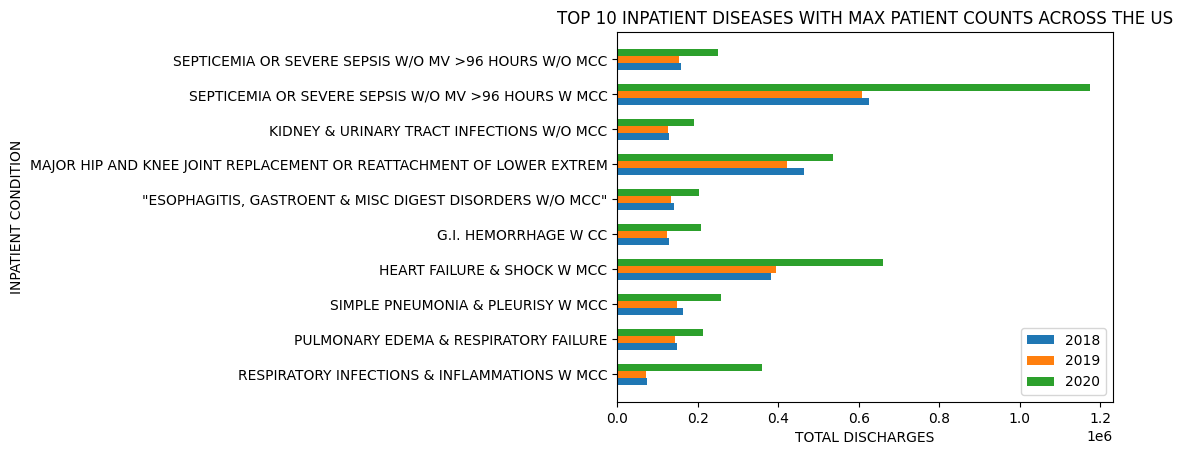

In [40]:
X = ihp_pt['DRG_DESC']
y = ihp_pt['TOT_DSCH_18']
z = ihp_pt['TOT_DSCH_19']
a = ihp_pt['TOT_DSCH_20']
  
Y_axis = np.arange(len(X))
  
plt.barh(Y_axis - 0.2, y, 0.2, label = '2018',align='center')
plt.barh(Y_axis, z, 0.2, label = '2019',align='center')
plt.barh(Y_axis + 0.2, a, 0.2, label = '2020',align='center')

plt.yticks(Y_axis, X)
plt.ylabel("INPATIENT CONDITION")
plt.xlabel("TOTAL DISCHARGES")
plt.title("TOP 10 INPATIENT DISEASES WITH MAX PATIENT COUNTS ACROSS THE US")
plt.legend()
plt.show()

In [41]:
ihp_pt4 = pd.read_sql_query("SELECT Prv_State, TOT_DSCH_18 from IHP_TOPDISCH_STATE_18 order by Prv_State" , conn)
ihp_pt4 = pd.DataFrame(ihp_pt4)
#print(ihp_pt4)
ihp_pt5 = pd.read_sql_query("SELECT Prv_State, TOT_DSCH_19 from IHP_TOPDISCH_STATE_19 order by Prv_State" , conn)
ihp_pt5 = pd.DataFrame(ihp_pt5)
#print(ihp_pt5)
ihp_pt6 = pd.read_sql_query("SELECT Prv_State, TOT_DSCH_20 from IHP_TOPDISCH_STATE_20 order by Prv_State" , conn)
ihp_pt6 = pd.DataFrame(ihp_pt6)
#print(ihp_pt6)
ihp_ptb = pd.concat([ihp_pt4, ihp_pt5['TOT_DSCH_19'] , ihp_pt6['TOT_DSCH_20']], axis=1)
ihp_ptb

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



Prv_State  TOT_DSCH_18  TOT_DSCH_19  TOT_DSCH_20
0        CA     536190.0     526766.0     896576.0
1        FL     566195.0     548276.0     952976.0
2        IL     324291.0     316887.0     531734.0
3        MA     225035.0     222575.0     387404.0
4        MI     269411.0     254397.0     400720.0
5        NC     257082.0     249423.0     414592.0
6        NY     428538.0     426884.0     715314.0
7        OH     277340.0     262206.0     432632.0
8        PA     316478.0     307961.0     513138.0
9        TX     491290.0     472628.0     801114.0

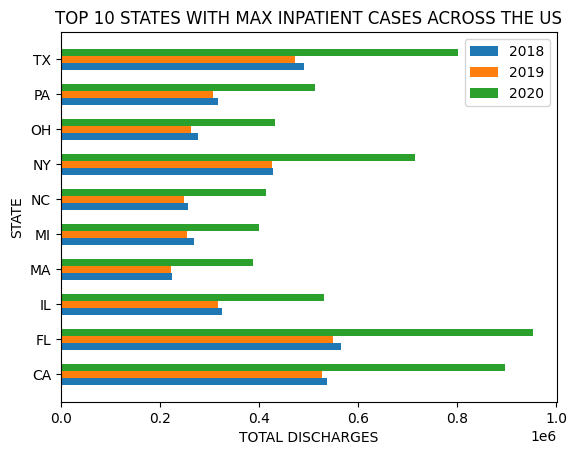

In [72]:
X = ihp_ptb['Prv_State']
y = ihp_ptb['TOT_DSCH_18']
z = ihp_ptb['TOT_DSCH_19']
a = ihp_ptb['TOT_DSCH_20']
  
Y_axis = np.arange(len(X))
  
plt.barh(Y_axis - 0.2, y, 0.2, label = '2018',align='center')
plt.barh(Y_axis, z, 0.2, label = '2019',align='center')
plt.barh(Y_axis + 0.2, a, 0.2, label = '2020',align='center')


plt.yticks(Y_axis, X)
plt.ylabel("STATE")
plt.xlabel("TOTAL DISCHARGES")
plt.title("TOP 10 STATES WITH MAX INPATIENT CASES ACROSS THE US")
plt.legend()
plt.show()

In [73]:
opd_pt1 = pd.read_sql_query("SELECT APC_Cd, APC_Desc, TOT_DSCH_18 from OPD_TOPDISCH_DISEASE_18 order by APC_Cd" , conn)
opd_pt1 = pd.DataFrame(opd_pt1)
#print(opd_pt1)
opd_pt2 = pd.read_sql_query("SELECT APC_Cd, APC_Desc, TOT_DSCH_19 from OPD_TOPDISCH_DISEASE_19 order by APC_Cd" , conn)
opd_pt2 = pd.DataFrame(opd_pt2)
#print(opd_pt2)
opd_pt3 = pd.read_sql_query("SELECT APC_Cd, APC_Desc, TOT_DSCH_20 from OPD_TOPDISCH_DISEASE_20 order by APC_Cd" , conn)
opd_pt3 = pd.DataFrame(opd_pt3)
#print(opd_pt3)
opd_pt = pd.concat([opd_pt1, opd_pt2['TOT_DSCH_19'] , opd_pt3['TOT_DSCH_20']], axis=1)
opd_pt

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



APC_Cd                                         APC_Desc  TOT_DSCH_18  \
0    5072  Level 2 Excision/ Biopsy/ Incision and Drainage     407260.0   
1    5114               Level 4 Musculoskeletal Procedures     215778.0   
2    5115               Level 5 Musculoskeletal Procedures     110308.0   
3    5191                  Level 1 Endovascular Procedures     345852.0   
4    5193                  Level 3 Endovascular Procedures     185780.0   
5    5302                      Level 2 Upper GI Procedures     191636.0   
6    5361         Level 1 Laparoscopy and Related Services     183598.0   
7    5373             Level 3 Urology and Related Services     148728.0   
8    5491                   Level 1 Intraocular Procedures     301074.0   
9    8011               Comprehensive Observation Services    1285469.0   

   TOT_DSCH_19  TOT_DSCH_20  
0     414186.0     303525.0  
1     210238.0     181656.0  
2     138447.0     221411.0  
3     348311.0     269497.0  
4     164919.0     136172.0  
5     195551.0     161761.0  
6     184621.0     154995.0  
7     158195.0     129782.0  
8     279931.0     198974.0  
9    1285953.0     920002.0

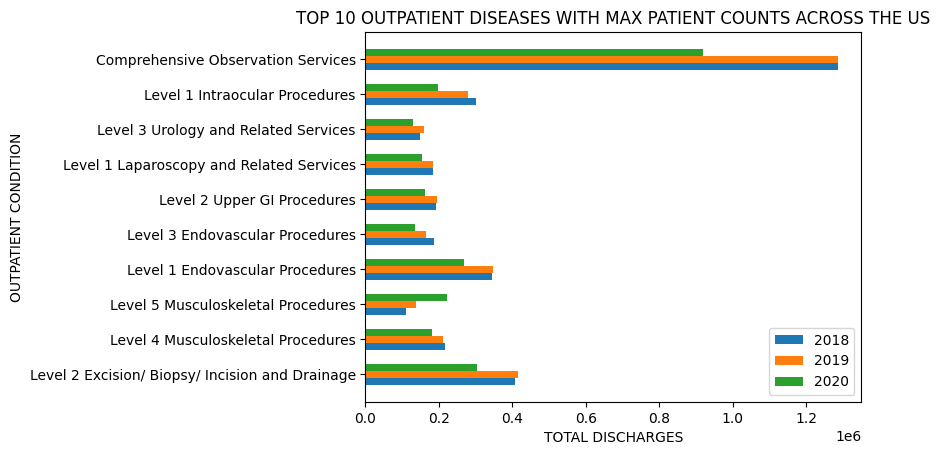

In [74]:
X = opd_pt['APC_Desc']
y = opd_pt['TOT_DSCH_18']
z = opd_pt['TOT_DSCH_19']
a = opd_pt['TOT_DSCH_20']
  
Y_axis = np.arange(len(X))
  
plt.barh(Y_axis - 0.2, y, 0.2, label = '2018',align='center')
plt.barh(Y_axis, z, 0.2, label = '2019',align='center')
plt.barh(Y_axis + 0.2, a, 0.2, label = '2020',align='center')

plt.yticks(Y_axis, X)
plt.ylabel("OUTPATIENT CONDITION")
plt.xlabel("TOTAL DISCHARGES")
plt.title("TOP 10 OUTPATIENT DISEASES WITH MAX PATIENT COUNTS ACROSS THE US")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



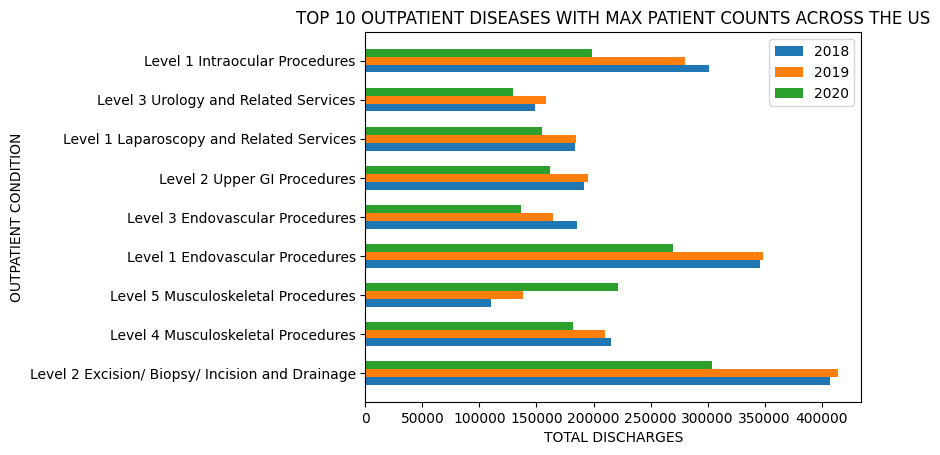

In [75]:
opd_pt4 = pd.read_sql_query("SELECT APC_Cd, APC_Desc, TOT_DSCH_18 from OPD_TOPDISCH_DISEASE_18 where APC_Desc not in ('Comprehensive Observation Services') order by APC_Cd" , conn)
opd_pt4 = pd.DataFrame(opd_pt4)
#print(opd_pt1)
opd_pt5 = pd.read_sql_query("SELECT APC_Cd, APC_Desc, TOT_DSCH_19 from OPD_TOPDISCH_DISEASE_19 where APC_Desc not in ('Comprehensive Observation Services') order by APC_Cd" , conn)
opd_pt5 = pd.DataFrame(opd_pt5)
#print(opd_pt2)
opd_pt6 = pd.read_sql_query("SELECT APC_Cd, APC_Desc, TOT_DSCH_20 from OPD_TOPDISCH_DISEASE_20 where APC_Desc not in ('Comprehensive Observation Services') order by APC_Cd" , conn)
opd_pt6 = pd.DataFrame(opd_pt6)
#print(opd_pt3)
opd_pt = pd.concat([opd_pt4, opd_pt5['TOT_DSCH_19'] , opd_pt6['TOT_DSCH_20']], axis=1)
opd_pt


X2 = opd_pt['APC_Desc']
y2 = opd_pt['TOT_DSCH_18']
z2 = opd_pt['TOT_DSCH_19']
a2 = opd_pt['TOT_DSCH_20']
  
Y_axis = np.arange(len(X2))
  
plt.barh(Y_axis - 0.2, y2, 0.2, label = '2018',align='center')
plt.barh(Y_axis, z2, 0.2, label = '2019',align='center')
plt.barh(Y_axis + 0.2, a2, 0.2, label = '2020',align='center')

plt.yticks(Y_axis, X2)
plt.ylabel("OUTPATIENT CONDITION")
plt.xlabel("TOTAL DISCHARGES")
plt.title("TOP 10 OUTPATIENT DISEASES WITH MAX PATIENT COUNTS ACROSS THE US")
plt.legend()
plt.show()

In [76]:
opd_pt4 = pd.read_sql_query("SELECT Prv_State, TOT_DSCH_18 from OPD_TOPDISCH_STATE_18 order by Prv_State" , conn)
opd_pt4 = pd.DataFrame(opd_pt4)
#print(opd_pt4)
opd_pt5 = pd.read_sql_query("SELECT Prv_State, TOT_DSCH_19 from OPD_TOPDISCH_STATE_19 order by Prv_State" , conn)
opd_pt5 = pd.DataFrame(opd_pt5)
#print(opd_pt5)
opd_pt6 = pd.read_sql_query("SELECT Prv_State, TOT_DSCH_20 from OPD_TOPDISCH_STATE_20 order by Prv_State" , conn)
opd_pt6 = pd.DataFrame(opd_pt6)
#print(opd_pt6)
opd_ptb = pd.concat([opd_pt4, opd_pt5['TOT_DSCH_19'] ,opd_pt6['TOT_DSCH_20']], axis=1)
opd_ptb

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



Prv_State  TOT_DSCH_18  TOT_DSCH_19  TOT_DSCH_20
0        CA     341822.0     369191.0     319892.0
1        FL     340871.0     362846.0     308157.0
2        IL     239651.0     250501.0     201929.0
3        MI     188026.0     197060.0     146141.0
4        NC     200742.0     212456.0     177677.0
5        NY     246461.0     263893.0     209620.0
6        OH     224049.0     235297.0     196517.0
7        PA     223045.0     237845.0     196270.0
8        TX     357465.0     382394.0     314420.0
9        VA     151077.0     160696.0     136231.0

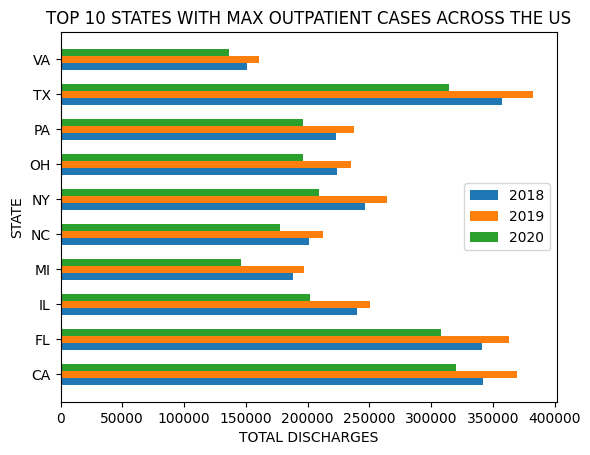

In [77]:
X = opd_ptb['Prv_State']
y = opd_ptb['TOT_DSCH_18']
z = opd_ptb['TOT_DSCH_19']
a = opd_ptb['TOT_DSCH_20']
  
Y_axis = np.arange(len(X))
  
plt.barh(Y_axis - 0.2, y, 0.2, label = '2018',align='center')
plt.barh(Y_axis, z, 0.2, label = '2019',align='center')
plt.barh(Y_axis + 0.2, a, 0.2, label = '2020',align='center')


plt.yticks(Y_axis, X)
plt.ylabel("STATE")
plt.xlabel("TOTAL DISCHARGES")
plt.title("TOP 10 STATES WITH MAX OUTPATIENT CASES ACROSS THE US")
plt.legend()
plt.show()

### Q3. Most Expensive Inpatient and Outpatient Conditions by Cost

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



                                            DRG_Desc   AVG_COST   MIN_COST  \
0  EXTENSIVE BURNS OR FULL THICKNESS BURNS WITH M...  349798.00  349798.00   
1  HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SY...  255544.73  137219.94   
2  "ECMO OR TRACHEOSTOMY WITH MV >96 HOURS OR PRI...  152122.67   61340.73   
3                                    LUNG TRANSPLANT  120612.78   69232.64   
4                  ALLOGENEIC BONE MARROW TRANSPLANT  117351.39   63064.36   

    MAX_COST  
0  349798.00  
1  472611.50  
2  434265.03  
3  217216.88  
4  204147.83  


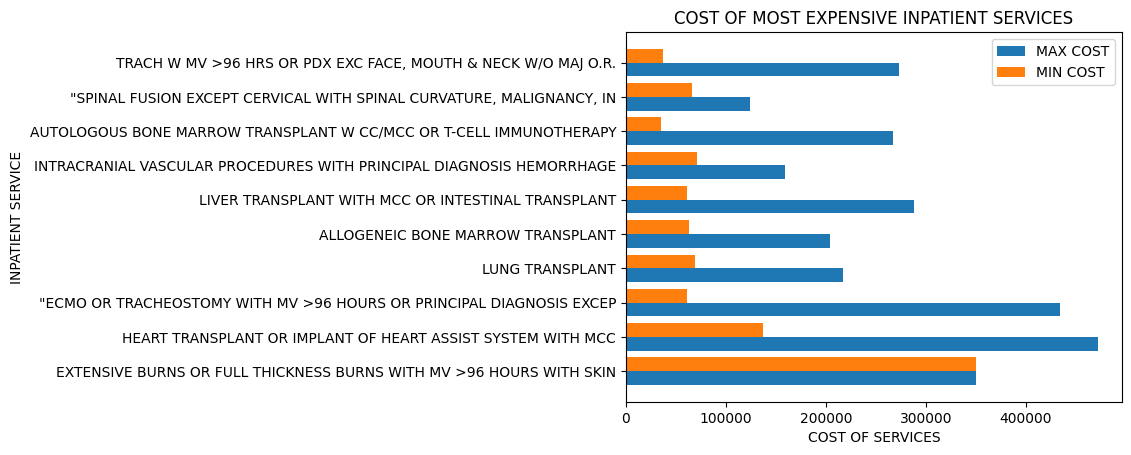

In [78]:
# Most expensive Inpatient Services

ihpxp = pd.read_sql_query("SELECT distinct ips.DRG_Desc, ROUND(AVG(ips.Avg_Mdcr_Pyt_Amt),2) AS AVG_COST, ROUND(MIN(ips.Avg_Mdcr_Pyt_Amt),2) AS MIN_COST, ROUND(Max(ips.Avg_Mdcr_Pyt_Amt),2) AS MAX_COST from Inpatient_2020_PrvSrv ips group by ips.DRG_Cd,ips.DRG_Desc ORDER BY ROUND(AVG(ips.Avg_Mdcr_Pyt_Amt),2)  DESC limit 10" , conn)
ihpxp = pd.DataFrame(ihpxp)
print(ihpxp.head())

X = ihpxp ['DRG_Desc']
y = ihpxp ['MAX_COST']
z = ihpxp ['MIN_COST']
  
y_axis = np.arange(len(X))
  
plt.barh(y_axis - 0.2, y, 0.4, label = 'MAX COST')
plt.barh(y_axis + 0.2, z, 0.4, label = 'MIN COST')

plt.yticks(y_axis, X)
plt.ylabel("INPATIENT SERVICE")
plt.xlabel("COST OF SERVICES")
plt.title("COST OF MOST EXPENSIVE INPATIENT SERVICES")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



                                            DRG_Desc  AVG_COST  MIN_COST  \
0  ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS...   5044.13   2053.00   
1          KIDNEY & URINARY TRACT INFECTIONS W/O MCC   5311.70   2670.93   
2                               G.I. HEMORRHAGE W CC   6618.58   2318.61   
3  SEPTICEMIA OR SEVERE SEPSIS WITHOUT MV >96 HOU...   7010.97   2778.57   
4            PULMONARY EDEMA AND RESPIRATORY FAILURE   8717.98   4685.36   

    MAX_COST  
0   40759.18  
1   44546.75  
2   42308.31  
3  121897.31  
4  128772.18  


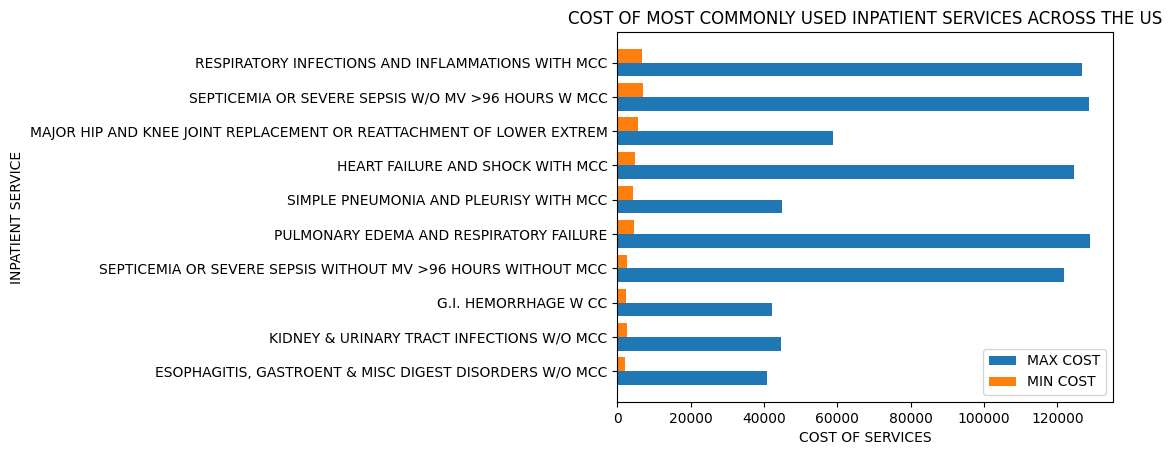

In [79]:
# Difference in Cost of Most Frequently used Inpatient Services in the US

ihpxp2 = pd.read_sql_query("SELECT distinct ips.DRG_Desc, ROUND(AVG(ips.Avg_Mdcr_Pyt_Amt),2) AS AVG_COST, ROUND(MIN(ips.Avg_Mdcr_Pyt_Amt),2) AS MIN_COST, ROUND(Max(ips.Avg_Mdcr_Pyt_Amt),2) AS MAX_COST from Inpatient_2020_PrvSrv ips WHERE DRG_CD IN (871,291,470,177,193,872,189,378,392,690) group by ips.DRG_Cd,ips.DRG_Desc ORDER BY ROUND(AVG(ips.Avg_Mdcr_Pyt_Amt),2)" , conn)
ihpxp2 = pd.DataFrame(ihpxp2)
print(ihpxp2.head())

X = ihpxp2 ['DRG_Desc']
y = ihpxp2 ['MAX_COST']
z = ihpxp2 ['MIN_COST']
  
y_axis = np.arange(len(X))
  
plt.barh(y_axis - 0.2, y, 0.4, label = 'MAX COST')
plt.barh(y_axis + 0.2, z, 0.4, label = 'MIN COST')

plt.yticks(y_axis, X)
plt.ylabel("INPATIENT SERVICE")
plt.xlabel("COST OF SERVICES")
plt.title("COST OF MOST COMMONLY USED INPATIENT SERVICES ACROSS THE US")
plt.legend()
plt.show()
             

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



                                            DRG_Desc  AVG_COST  MIN_COST  \
0  ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS...   4527.40   2827.09   
1          KIDNEY & URINARY TRACT INFECTIONS W/O MCC   4710.44   3518.74   
2                               G.I. HEMORRHAGE W CC   6116.09   4954.94   
3  SEPTICEMIA OR SEVERE SEPSIS WITHOUT MV >96 HOU...   6301.14   5035.43   
4            PULMONARY EDEMA AND RESPIRATORY FAILURE   7811.01   6302.72   

   MAX_COST  
0  11482.83  
1   6671.33  
2  13402.48  
3  13684.58  
4  15831.58  


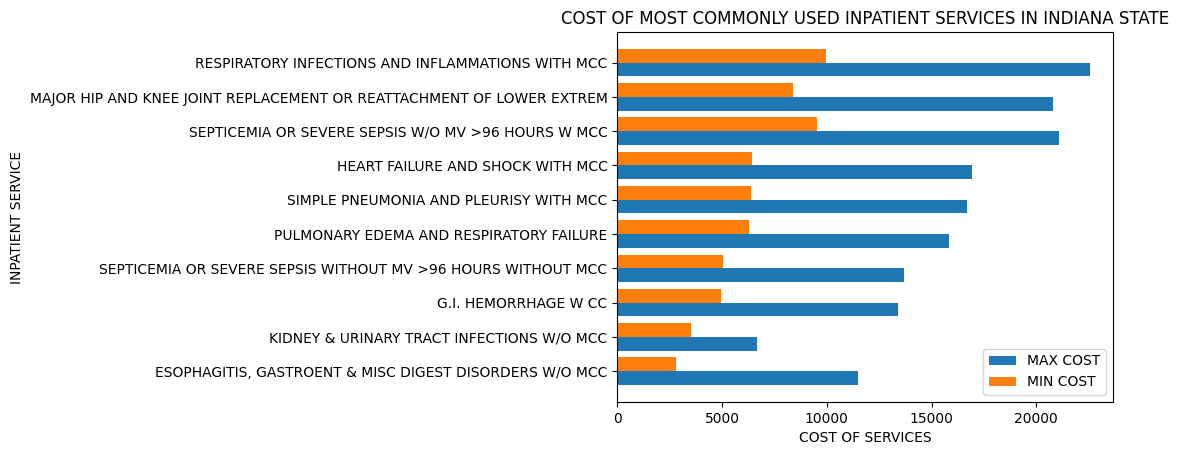

In [80]:
# Difference in Cost of Most Frequently used Inpatient Services in Indiana State

ihpxp3 = pd.read_sql_query("SELECT distinct ips.DRG_Desc, ROUND(AVG(ips.Avg_Mdcr_Pyt_Amt),2) AS AVG_COST, ROUND(MIN(ips.Avg_Mdcr_Pyt_Amt),2) AS MIN_COST, ROUND(Max(ips.Avg_Mdcr_Pyt_Amt),2) AS MAX_COST from Inpatient_2020_PrvSrv ips WHERE DRG_CD IN (871,291,470,177,193,872,189,378,392,690) AND Prv_State = 'IN' group by ips.DRG_Cd,ips.DRG_Desc ORDER BY ROUND(AVG(ips.Avg_Mdcr_Pyt_Amt),2)" , conn)
ihpxp3 = pd.DataFrame(ihpxp3)
print(ihpxp3.head())

X = ihpxp3 ['DRG_Desc']
y = ihpxp3 ['MAX_COST']
z = ihpxp3 ['MIN_COST']
  
y_axis = np.arange(len(X))
  
plt.barh(y_axis - 0.2, y, 0.4, label = 'MAX COST')
plt.barh(y_axis + 0.2, z, 0.4, label = 'MIN COST')

plt.yticks(y_axis, X)
plt.ylabel("INPATIENT SERVICE")
plt.xlabel("COST OF SERVICES")
plt.title("COST OF MOST COMMONLY USED INPATIENT SERVICES IN INDIANA STATE")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



                                     Outpatient_Serv  AVG_COST  MIN_COST  \
0  Level 4 Blood Product Exchange and Related Ser...  43148.73  37281.32   
1                         Cochlear Implant Procedure  31393.97  22172.11   
2                 Level 2 ICD and Similar Procedures  30404.31  10629.67   
3          Implantation Wireless PA Pressure Monitor  27200.47  23396.99   
4     Level 4 Neurostimulator and Related Procedures  26744.63  14485.75   

   MAX_COST  
0  53797.48  
1  47138.93  
2  47202.44  
3  33072.17  
4  41360.33  


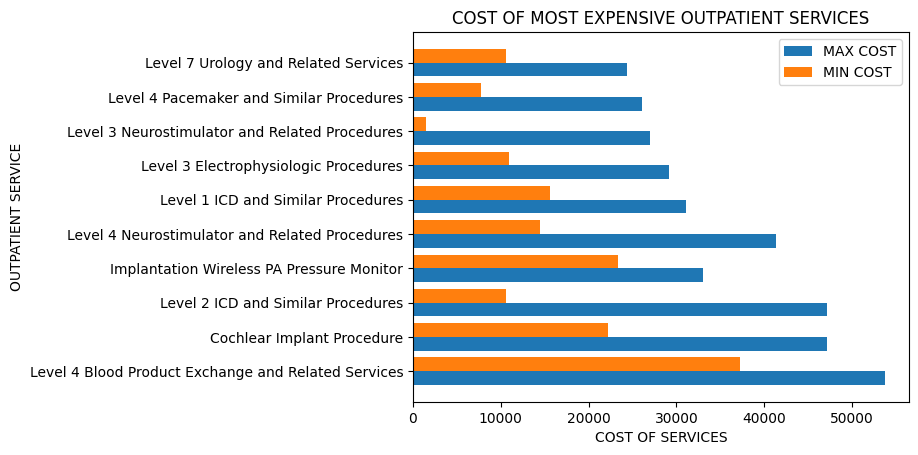

In [81]:
# Most expensive Outpatient Services

ihpxp = pd.read_sql_query("SELECT distinct APC_Desc as Outpatient_Serv, ROUND(AVG(Avg_Mdcr_Pymt_Amt),2) AS AVG_COST, ROUND(MIN(Avg_Mdcr_Pymt_Amt),2) AS MIN_COST, ROUND(Max(Avg_Mdcr_Pymt_Amt),2) AS MAX_COST from Outpatient_2020_PrvSrv where (Avg_Mdcr_Pymt_Amt != 0.0) group by APC_Cd,APC_Desc ORDER BY ROUND(AVG(Avg_Mdcr_Pymt_Amt),2) DESC limit 10" , conn)
ihpxp = pd.DataFrame(ihpxp)
print(ihpxp.head())

X = ihpxp ['Outpatient_Serv']
y = ihpxp ['MAX_COST']
z = ihpxp ['MIN_COST']
  
y_axis = np.arange(len(X))
  
plt.barh(y_axis - 0.2, y, 0.4, label = 'MAX COST')
plt.barh(y_axis + 0.2, z, 0.4, label = 'MIN COST')

plt.yticks(y_axis, X)
plt.ylabel("OUTPATIENT SERVICE")
plt.xlabel("COST OF SERVICES")
plt.title("COST OF MOST EXPENSIVE OUTPATIENT SERVICES")
plt.legend()
plt.show()
                          

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



                                   Outpatient_Serv  AVG_COST  MIN_COST  \
0  Level 2 Excision/ Biopsy/ Incision and Drainage   1075.79    437.40   
1                      Level 2 Upper GI Procedures   1221.80    460.73   
2             Level 3 Urology and Related Services   1388.32    606.22   
3                   Level 1 Intraocular Procedures   1588.50    276.48   
4               Comprehensive Observation Services   1806.92     59.13   

   MAX_COST  
0   1657.13  
1   1875.00  
2   2137.77  
3   2415.98  
4   3065.11  


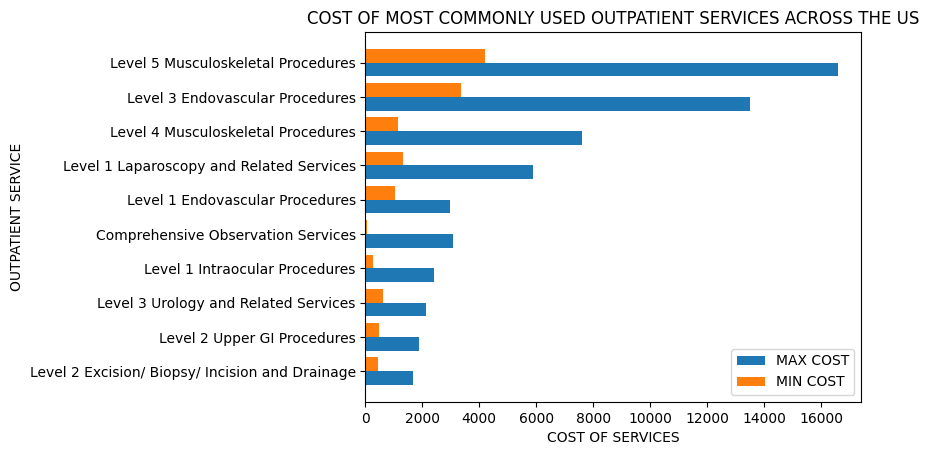

In [82]:
# Difference in Cost of Most Frequently used Outpatient Services in the US

opxp2 = pd.read_sql_query("SELECT distinct APC_Desc as Outpatient_Serv, ROUND(AVG(Avg_Mdcr_Pymt_Amt),2) AS AVG_COST, ROUND(MIN(Avg_Mdcr_Pymt_Amt),2) AS MIN_COST, ROUND(Max(Avg_Mdcr_Pymt_Amt),2) AS MAX_COST from Outpatient_2020_PrvSrv where (Avg_Mdcr_Pymt_Amt != 0.0) AND APC_Cd IN (8011,5072,5191,5115,5491,5114,5302,5361,5193,5373) group by APC_Cd,APC_Desc ORDER BY ROUND(AVG(Avg_Mdcr_Pymt_Amt),2)" , conn)
opxp2 = pd.DataFrame(opxp2)
print(opxp2.head())

X = opxp2 ['Outpatient_Serv']
y = opxp2 ['MAX_COST']
z = opxp2 ['MIN_COST']
  
y_axis = np.arange(len(X))
  
plt.barh(y_axis - 0.2, y, 0.4, label = 'MAX COST')
plt.barh(y_axis + 0.2, z, 0.4, label = 'MIN COST')

plt.yticks(y_axis, X)
plt.ylabel("OUTPATIENT SERVICE")
plt.xlabel("COST OF SERVICES")
plt.title("COST OF MOST COMMONLY USED OUTPATIENT SERVICES ACROSS THE US")
plt.legend()
plt.show()



/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



                                   Outpatient_Serv  AVG_COST  MIN_COST  \
0  Level 2 Excision/ Biopsy/ Incision and Drainage   1054.05    961.23   
1                      Level 2 Upper GI Procedures   1185.83    980.92   
2             Level 3 Urology and Related Services   1365.18   1249.37   
3                   Level 1 Intraocular Procedures   1500.68    276.48   
4               Comprehensive Observation Services   1759.91   1561.68   

   MAX_COST  
0   1148.50  
1   1307.82  
2   1443.70  
3   1629.20  
4   1965.49  


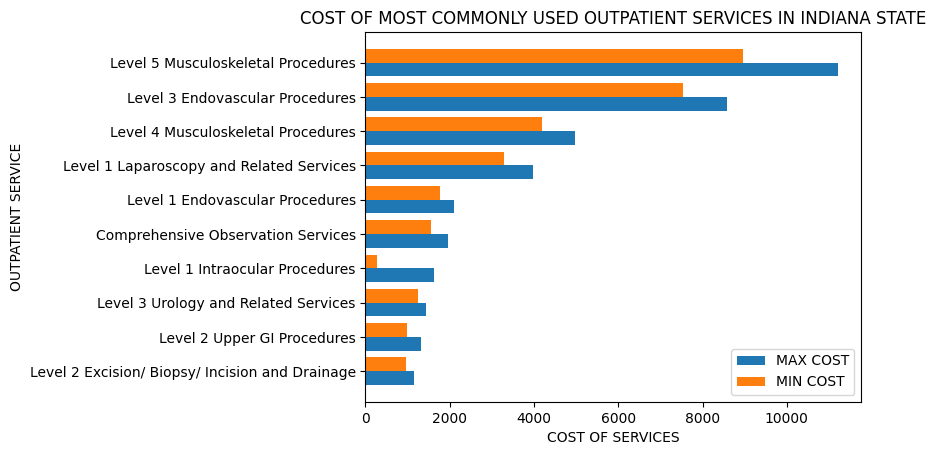

In [83]:
# Difference in Cost of Most Frequently used Outpatient Services in Indiana State

opxp3 = pd.read_sql_query("SELECT distinct APC_Desc as Outpatient_Serv, ROUND(AVG(Avg_Mdcr_Pymt_Amt),2) AS AVG_COST, ROUND(MIN(Avg_Mdcr_Pymt_Amt),2) AS MIN_COST, ROUND(Max(Avg_Mdcr_Pymt_Amt),2) AS MAX_COST from Outpatient_2020_PrvSrv where (Avg_Mdcr_Pymt_Amt != 0.0) AND APC_Cd IN (8011,5072,5191,5115,5491,5114,5302,5361,5193,5373) AND Prv_State = 'IN' group by APC_Cd,APC_Desc ORDER BY ROUND(AVG(Avg_Mdcr_Pymt_Amt),2)" , conn)
opxp3 = pd.DataFrame(opxp3)
print(opxp3.head())

X = opxp3 ['Outpatient_Serv']
y = opxp3 ['MAX_COST']
z = opxp3 ['MIN_COST']
  
y_axis = np.arange(len(X))
  
plt.barh(y_axis - 0.2, y, 0.4, label = 'MAX COST')
plt.barh(y_axis + 0.2, z, 0.4, label = 'MIN COST')

plt.yticks(y_axis, X)
plt.ylabel("OUTPATIENT SERVICE")
plt.xlabel("COST OF SERVICES")
plt.title("COST OF MOST COMMONLY USED OUTPATIENT SERVICES IN INDIANA STATE")
plt.legend()
plt.show()

### Q4.Average HCC scores across States and Indiana Cities

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



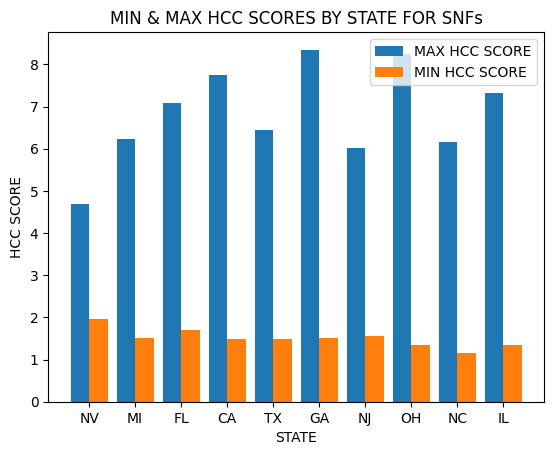

In [84]:
snf_hcc = pd.read_sql_query("SELECT STATE, ROUND(AVG(BENE_AVG_RISK_SCRE),2) AS AVG_HCC_SCORE, ROUND(MAX(BENE_AVG_RISK_SCRE),2) AS MAX_HCC_SCORE, ROUND(MIN(BENE_AVG_RISK_SCRE),2) AS MIN_HCC_SCORE, COUNT(BENE_AVG_RISK_SCRE) AS TOTAL_FACILITIES FROM MD_PAC_SNF_2020 where STATE != 'NATIONAL TOTAL' GROUP BY STATE ORDER BY AVG_HCC_SCORE DESC LIMIT 10" , conn)
snf_hcc = pd.DataFrame(snf_hcc)
snf_hcc.head()

X = snf_hcc['STATE']
y = snf_hcc['MAX_HCC_SCORE']
z = snf_hcc['MIN_HCC_SCORE']
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, y, 0.4, label = 'MAX HCC SCORE')
plt.bar(X_axis + 0.2, z, 0.4, label = 'MIN HCC SCORE')

plt.xticks(X_axis, X)
plt.xlabel("STATE")
plt.ylabel("HCC SCORE")
plt.title("MIN & MAX HCC SCORES BY STATE FOR SNFs")
plt.legend()
plt.show()

In [85]:
snf_hcc2 = pd.read_sql_query("SELECT STATE, ROUND(AVG(BENE_AVG_RISK_SCRE),2) AS AVG_HCC_SCORE, ROUND(MAX(BENE_AVG_RISK_SCRE),2) AS MAX_HCC_SCORE, ROUND(MIN(BENE_AVG_RISK_SCRE),2) AS MIN_HCC_SCORE, COUNT(BENE_AVG_RISK_SCRE) AS TOTAL_FACILITIES FROM MD_PAC_SNF_2020 where STATE != 'NATIONAL TOTAL' GROUP BY STATE ORDER BY AVG_HCC_SCORE DESC" , conn)
snf_hcc2 = pd.DataFrame(snf_hcc2)
snf_hcc2.head()

trace1 = go.Bar(
    x=snf_hcc2.STATE,
    y=snf_hcc2.MAX_HCC_SCORE,
    name='Max HCC Score',
    marker=dict(color='rgb(158,202,225)'),
)
trace2 = go.Bar(
    x=snf_hcc2.STATE,
    y=snf_hcc2.MIN_HCC_SCORE,
    name='Min HCC Score',
    marker=dict(color='rgb(58,22,25)'),
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    title='Minimum and Maximum HCC scores for SNF facilities in different States',
    legend=dict(orientation="h")
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



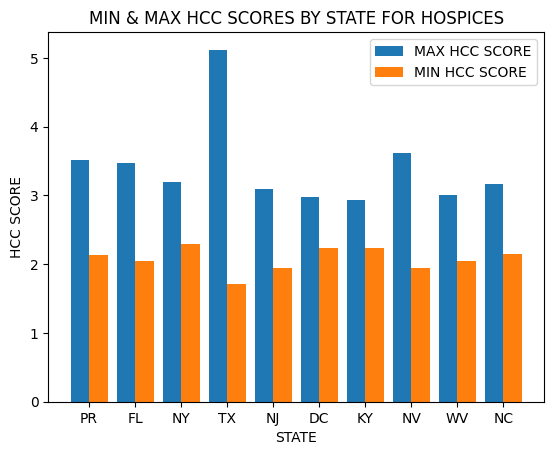

In [86]:
hos_hcc = pd.read_sql_query("SELECT STATE, ROUND(AVG(BENE_AVG_RISK_SCRE),2) AS AVG_HCC_SCORE, ROUND(MAX(BENE_AVG_RISK_SCRE),2) AS MAX_HCC_SCORE, ROUND(MIN(BENE_AVG_RISK_SCRE),2) AS MIN_HCC_SCORE, COUNT(BENE_AVG_RISK_SCRE) AS TOTAL_FACILITIES FROM MD_PAC_HOS_2020 where STATE != 'NATIONAL TOTAL' GROUP BY STATE ORDER BY AVG_HCC_SCORE DESC LIMIT 10" , conn)
hos_hcc = pd.DataFrame(hos_hcc)
hos_hcc.head()

X = hos_hcc['STATE']
y = hos_hcc['MAX_HCC_SCORE']
z = hos_hcc['MIN_HCC_SCORE']
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, y, 0.4, label = 'MAX HCC SCORE')
plt.bar(X_axis + 0.2, z, 0.4, label = 'MIN HCC SCORE')

plt.xticks(X_axis, X)
plt.xlabel("STATE")
plt.ylabel("HCC SCORE")
plt.title("MIN & MAX HCC SCORES BY STATE FOR HOSPICES")
plt.legend()
plt.show()

In [87]:
hos_hcc2 = pd.read_sql_query("SELECT STATE, ROUND(AVG(BENE_AVG_RISK_SCRE),2) AS AVG_HCC_SCORE, ROUND(MAX(BENE_AVG_RISK_SCRE),2) AS MAX_HCC_SCORE, ROUND(MIN(BENE_AVG_RISK_SCRE),2) AS MIN_HCC_SCORE, COUNT(BENE_AVG_RISK_SCRE) AS TOTAL_FACILITIES FROM MD_PAC_HOS_2020 where STATE != 'NATIONAL TOTAL' GROUP BY STATE ORDER BY AVG_HCC_SCORE DESC" , conn)
hos_hcc2 = pd.DataFrame(hos_hcc2)
hos_hcc2.head()

trace1 = go.Bar(
    x=hos_hcc2.STATE,
    y=hos_hcc2.MAX_HCC_SCORE,
    name='Max HCC Score',
    marker=dict(color='rgb(158,202,225)'),
)
trace2 = go.Bar(
    x=hos_hcc2.STATE,
    y=hos_hcc2.MIN_HCC_SCORE,
    name='Min HCC Score',
    marker=dict(color='rgb(58,22,25)'),
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    title='Minimum and Maximum HCC scores for Hospice facilities in different States',
    legend=dict(orientation="h")
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



### INDIANA LEVEL

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



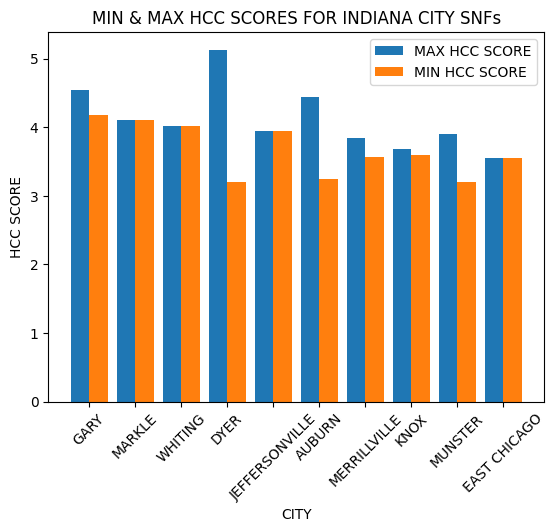

In [88]:
snf_hccct = pd.read_sql_query(" SELECT PRVDR_CITY, ROUND(AVG(BENE_AVG_RISK_SCRE),2) AS AVG_HCC_SCORE, ROUND(MAX(BENE_AVG_RISK_SCRE),2) AS MAX_HCC_SCORE, ROUND(MIN(BENE_AVG_RISK_SCRE),2) AS MIN_HCC_SCORE, COUNT(BENE_AVG_RISK_SCRE) AS TOTAL_FACILITIES FROM MD_PAC_SNF_2020 where STATE = 'IN' GROUP BY PRVDR_CITY ORDER BY AVG_HCC_SCORE DESC LIMIT 10" , conn)
snf_hccct = pd.DataFrame(snf_hccct)
snf_hccct.head()

X = snf_hccct['PRVDR_CITY']
y = snf_hccct['MAX_HCC_SCORE']
z = snf_hccct['MIN_HCC_SCORE']
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, y, 0.4, label = 'MAX HCC SCORE')
plt.bar(X_axis + 0.2, z, 0.4, label = 'MIN HCC SCORE')

plt.xticks(X_axis, X, rotation = 45)
plt.xlabel("CITY")
plt.ylabel("HCC SCORE")
plt.title("MIN & MAX HCC SCORES FOR INDIANA CITY SNFs")
plt.legend()
plt.show()

In [89]:
snf_hccct2 = pd.read_sql_query(" SELECT PRVDR_CITY, ROUND(AVG(BENE_AVG_RISK_SCRE),2) AS AVG_HCC_SCORE, ROUND(MAX(BENE_AVG_RISK_SCRE),2) AS MAX_HCC_SCORE, ROUND(MIN(BENE_AVG_RISK_SCRE),2) AS MIN_HCC_SCORE, COUNT(BENE_AVG_RISK_SCRE) AS TOTAL_FACILITIES FROM MD_PAC_SNF_2020 where STATE = 'IN' GROUP BY PRVDR_CITY ORDER BY AVG_HCC_SCORE DESC LIMIT 20" , conn)
snf_hccct2 = pd.DataFrame(snf_hccct2)
snf_hccct2.head()

trace1 = go.Bar(
    x=snf_hccct2.PRVDR_CITY,
    y=snf_hccct2.MAX_HCC_SCORE,
    name='Max HCC Score',
    marker=dict(color='rgb(158,202,225)'),
)
trace2 = go.Bar(
    x=snf_hccct2.PRVDR_CITY,
    y=snf_hccct2.MIN_HCC_SCORE,
    name='Min HCC Score',
    marker=dict(color='rgb(58,22,25)'),
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    title='Minimum and Maximum HCC scores for Indiana SNF facilities in different cities',
    legend=dict(orientation="h")
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



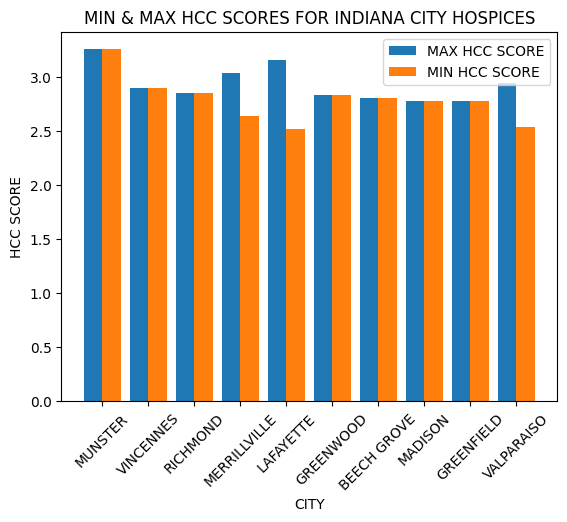

In [90]:
hos_hccct = pd.read_sql_query(" SELECT PRVDR_CITY, ROUND(AVG(BENE_AVG_RISK_SCRE),2) AS AVG_HCC_SCORE, ROUND(MAX(BENE_AVG_RISK_SCRE),2) AS MAX_HCC_SCORE, ROUND(MIN(BENE_AVG_RISK_SCRE),2) AS MIN_HCC_SCORE, COUNT(BENE_AVG_RISK_SCRE) AS TOTAL_FACILITIES FROM MD_PAC_HOS_2020 where STATE = 'IN' GROUP BY PRVDR_CITY ORDER BY AVG_HCC_SCORE DESC LIMIT 10" , conn)
hos_hccct = pd.DataFrame(hos_hccct)
hos_hccct.head()

X = hos_hccct['PRVDR_CITY']
y = hos_hccct['MAX_HCC_SCORE']
z = hos_hccct['MIN_HCC_SCORE']
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, y, 0.4, label = 'MAX HCC SCORE')
plt.bar(X_axis + 0.2, z, 0.4, label = 'MIN HCC SCORE')

plt.xticks(X_axis, X, rotation = 45)
plt.xlabel("CITY")
plt.ylabel("HCC SCORE")
plt.title("MIN & MAX HCC SCORES FOR INDIANA CITY HOSPICES")
plt.legend()
plt.show()

In [91]:
hos_hccct2 = pd.read_sql_query(" SELECT PRVDR_CITY, ROUND(AVG(BENE_AVG_RISK_SCRE),2) AS AVG_HCC_SCORE, ROUND(MAX(BENE_AVG_RISK_SCRE),2) AS MAX_HCC_SCORE, ROUND(MIN(BENE_AVG_RISK_SCRE),2) AS MIN_HCC_SCORE, COUNT(BENE_AVG_RISK_SCRE) AS TOTAL_FACILITIES FROM MD_PAC_HOS_2020 where STATE = 'IN' GROUP BY PRVDR_CITY ORDER BY AVG_HCC_SCORE DESC LIMIT 20" , conn)
hos_hccct2 = pd.DataFrame(hos_hccct2)
hos_hccct2.head()

trace1 = go.Bar(
    x=hos_hccct2.PRVDR_CITY,
    y=hos_hccct2.MAX_HCC_SCORE,
    name='Max HCC Score',
    marker=dict(color='rgb(158,202,225)'),
)
trace2 = go.Bar(
    x=hos_hccct2.PRVDR_CITY,
    y=hos_hccct2.MIN_HCC_SCORE,
    name='Min HCC Score',
    marker=dict(color='rgb(58,22,25)'),
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    title='Minimum and Maximum HCC scores for Indiana Hospice facilities in different cities',
    legend=dict(orientation="h")
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



### Q3. Distribution of Male and Female Beneficiaries across States and in Indiana

In [92]:
snf_mafm = pd.read_sql_query(" SELECT STATE, ROUND(((SUM(BENE_MALE_PCT)/COUNT(BENE_MALE_PCT))*100),2) AS MALE_BENE,ROUND(((SUM(BENE_FEML_PCT)/COUNT(BENE_FEML_PCT))*100),2) AS FEMALE_BENE FROM MD_PAC_SNF_2020 WHERE PRVDR_NAME != 'STATE TOTAL' AND STATE != 'NATIONAL TOTAL' GROUP BY STATE ORDER BY ((SUM(BENE_MALE_PCT)/COUNT(BENE_MALE_PCT))*100) DESC" , conn)
snf_mafm = pd.DataFrame(snf_mafm)
snf_mafm.head()

trace1 = go.Bar(
    x=snf_mafm.STATE,
    y=snf_mafm.MALE_BENE,
    marker=dict(color='#e584f7'),
    name='Percent Male beneficiaries'
)
trace2 = go.Bar(
    x=snf_mafm.STATE,
    y=snf_mafm.FEMALE_BENE,
    marker=dict(color='#a0f784'),
    name='Percent Female beneficiaries'
)

data = [trace1, trace2]
layout = go.Layout(barmode='group', legend=dict(orientation='h'), title='Percent of Male and Female Patients in 2020 in SNFs in different states')
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [93]:
snf_mafmct = pd.read_sql_query(" SELECT PRVDR_CITY, ROUND(((SUM(BENE_MALE_PCT)/COUNT(BENE_MALE_PCT))*100),2) AS MALE_BENE, ROUND(((SUM(BENE_FEML_PCT)/COUNT(BENE_FEML_PCT))*100),2) AS FEMALE_BENE FROM MD_PAC_SNF_2020 WHERE PRVDR_NAME != 'STATE TOTAL' AND STATE != 'NATIONAL TOTAL' GROUP BY PRVDR_CITY ORDER BY COUNT(BENE_MALE_PCT) DESC LIMIT 20" , conn)
snf_mafmct = pd.DataFrame(snf_mafmct)
snf_mafmct.head()

trace1 = go.Bar(
    x=snf_mafmct.PRVDR_CITY,
    y=snf_mafmct.MALE_BENE,
    marker=dict(color='#e584f7'),
    name='Percent Male beneficiaries'
)
trace2 = go.Bar(
    x=snf_mafmct.PRVDR_CITY,
    y=snf_mafmct.FEMALE_BENE,
    marker=dict(color='#a0f784'),
    name='Percent Female beneficiaries'
)

data = [trace1, trace2]
layout = go.Layout(barmode='group', legend=dict(orientation='h'), title='Percent of Male and Female Patients in 2020 in SNFs in the Top 20 Cities across the US')
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [94]:
hos_mafm = pd.read_sql_query(" SELECT STATE, ROUND(((SUM(BENE_MALE_PCT)/COUNT(BENE_MALE_PCT))*100),2) AS MALE_BENE,ROUND(((SUM(BENE_FEML_PCT)/COUNT(BENE_FEML_PCT))*100),2) AS FEMALE_BENE FROM MD_PAC_HOS_2020 WHERE PRVDR_NAME != 'STATE TOTAL' AND STATE != 'NATIONAL TOTAL' GROUP BY STATE ORDER BY ((SUM(BENE_MALE_PCT)/COUNT(BENE_MALE_PCT))*100) DESC" , conn)
hos_mafm = pd.DataFrame(hos_mafm)
hos_mafm.head()

trace1 = go.Bar(
    x=hos_mafm.STATE,
    y=hos_mafm.MALE_BENE,
    marker=dict(color='#e584f7'),
    name='Percent Male beneficiaries'
)
trace2 = go.Bar(
    x=hos_mafm.STATE,
    y=hos_mafm.FEMALE_BENE,
    marker=dict(color='#a0f784'),
    name='Percent Female beneficiaries'
)

data = [trace1, trace2]
layout = go.Layout(barmode='group', legend=dict(orientation='h'), title='Percent of Male and Female Patients in 2020 in Hospices in STATES across the US')
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



In [95]:
hos_mafmct = pd.read_sql_query(" SELECT PRVDR_CITY, ROUND(((SUM(BENE_MALE_PCT)/COUNT(BENE_MALE_PCT))*100),2) AS MALE_BENE, ROUND(((SUM(BENE_FEML_PCT)/COUNT(BENE_FEML_PCT))*100),2) AS FEMALE_BENE FROM MD_PAC_HOS_2020 WHERE PRVDR_NAME != 'STATE TOTAL' AND STATE != 'NATIONAL TOTAL' GROUP BY PRVDR_CITY ORDER BY COUNT(BENE_MALE_PCT) DESC LIMIT 20" , conn)
hos_mafmct = pd.DataFrame(hos_mafmct)
hos_mafmct.head()

trace1 = go.Bar(
    x=hos_mafmct.PRVDR_CITY,
    y=hos_mafmct.MALE_BENE,
    marker=dict(color='#e584f7'),
    name='Percent Male beneficiaries'
)
trace2 = go.Bar(
    x=hos_mafmct.PRVDR_CITY,
    y=hos_mafmct.FEMALE_BENE,
    marker=dict(color='#a0f784'),
    name='Percent Female beneficiaries'
)

data = [trace1, trace2]
layout = go.Layout(barmode='group', legend=dict(orientation='h'), title='Percent of Male and Female Patients in 2020 in Hospices in the Top 20 Cities across the US')
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



### Q5. Access to Care by Ethnicity at national and State Levels

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



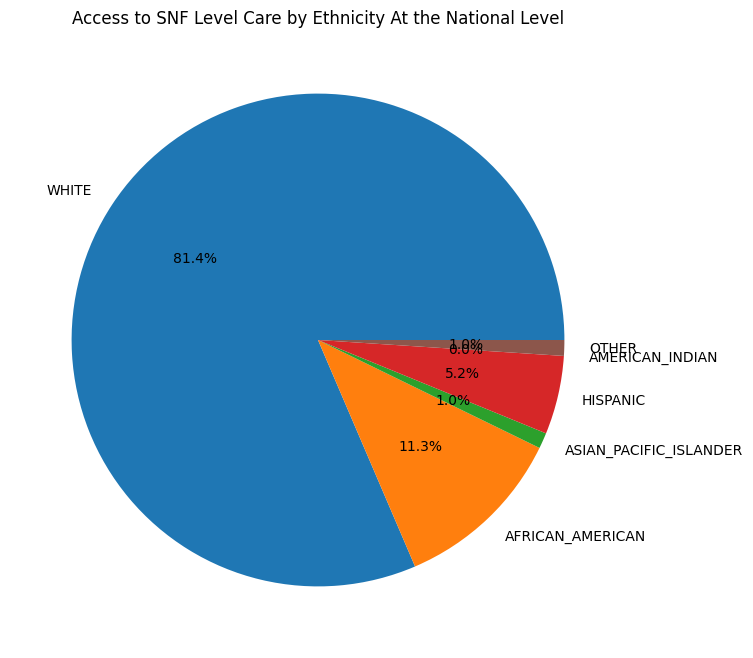

In [96]:
snf_ethn = pd.read_sql_query("SELECT ROUND(BENE_RACE_WHT_PCT*100,2) AS WHITE, ROUND(BENE_RACE_BLACK_PCT*100,2) AS AFRICAN_AMERICAN, ROUND(BENE_RACE_API_PCT*100,2) AS ASIAN_PACIFIC_ISLANDER, ROUND(BENE_RACE_HSPNC_PCT*100,2) AS HISPANIC, ROUND(BENE_RACE_NATIND_PCT*100,2) AS AMERICAN_INDIAN, ROUND(BENE_RACE_OTHR_PCT*100,2) AS OTHER FROM MD_PAC_SNF_2020 WHERE STATE = 'NATIONAL TOTAL'" , conn)
snf_ethn = pd.DataFrame(snf_ethn)
snf_ethn = snf_ethn.T
snf_ethn.columns=['Percent']
snf_ethn = snf_ethn.assign(Race=['WHITE', 'AFRICAN_AMERICAN', 'ASIAN_PACIFIC_ISLANDER','HISPANIC','AMERICAN_INDIAN','OTHER'])
snf_ethn

fig, sc = plt.subplots(figsize=(8, 8))
sc.pie(snf_ethn['Percent'], labels=snf_ethn['Race'], autopct='%.1f%%')
sc.set_title("Access to SNF Level Care by Ethnicity At the National Level")
plt.show()

In [97]:
snf_ethn_st = pd.read_sql_query("SELECT STATE, ROUND(BENE_RACE_WHT_PCT*100,2) AS WHITE, ROUND(BENE_RACE_BLACK_PCT*100,2) AS AFRICAN_AMERICAN, ROUND(BENE_RACE_API_PCT*100,2) AS ASIAN_PACIFIC_ISLANDER, ROUND(BENE_RACE_HSPNC_PCT*100,2) AS HISPANIC, ROUND(BENE_RACE_NATIND_PCT*100,2) AS AMERICAN_INDIAN, ROUND(BENE_RACE_OTHR_PCT*100,2) AS OTHER FROM MD_PAC_SNF_2020 WHERE SMRY_CTGRY = 'STATE'" , conn)
snf_ethn_st = pd.DataFrame(snf_ethn_st)
snf_ethn_st.head()


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



STATE  WHITE  AFRICAN_AMERICAN  ASIAN_PACIFIC_ISLANDER  HISPANIC  \
0    AK   78.0               3.0                     3.0       2.0   
1    AL   80.0              18.0                     0.0       0.0   
2    AR   86.0              10.0                     0.0       0.0   
3    AZ   81.0               2.0                     0.0       7.0   
4    CA   62.0               8.0                     9.0      16.0   

   AMERICAN_INDIAN  OTHER  
0              9.0    2.0  
1              0.0    0.0  
2              0.0    0.0  
3              6.0    1.0  
4              0.0    1.0

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



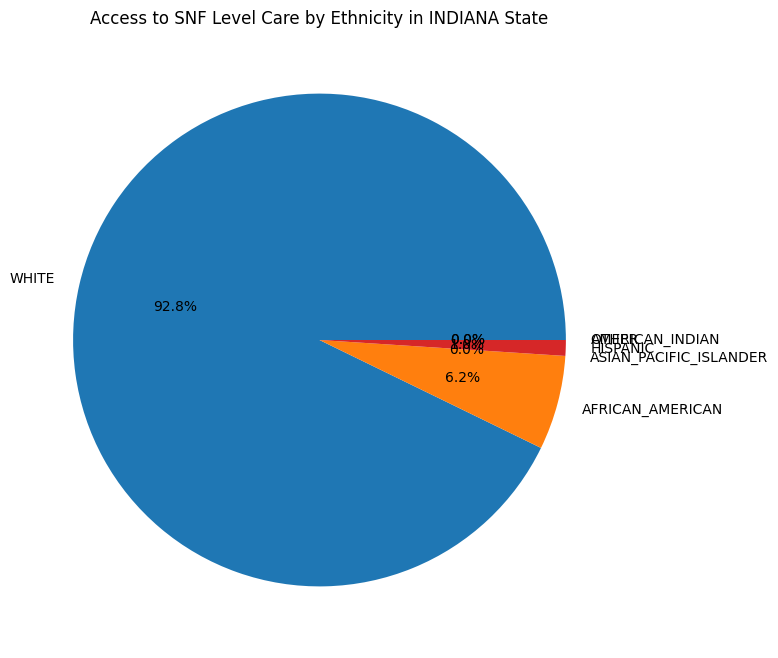

In [98]:
snf_ethnin = pd.read_sql_query("SELECT ROUND(BENE_RACE_WHT_PCT*100,2) AS WHITE, ROUND(BENE_RACE_BLACK_PCT*100,2) AS AFRICAN_AMERICAN, ROUND(BENE_RACE_API_PCT*100,2) AS ASIAN_PACIFIC_ISLANDER, ROUND(BENE_RACE_HSPNC_PCT*100,2) AS HISPANIC, ROUND(BENE_RACE_NATIND_PCT*100,2) AS AMERICAN_INDIAN, ROUND(BENE_RACE_OTHR_PCT*100,2) AS OTHER FROM MD_PAC_SNF_2020 WHERE STATE = 'IN' and SMRY_CTGRY =  'STATE'" , conn)
snf_ethnin = pd.DataFrame(snf_ethnin)
snf_ethnin
snf_ethnin = snf_ethnin.T
snf_ethnin.columns=['Percent']
snf_ethnin = snf_ethnin.assign(Race=['WHITE', 'AFRICAN_AMERICAN', 'ASIAN_PACIFIC_ISLANDER','HISPANIC','AMERICAN_INDIAN','OTHER'])
snf_ethnin

fig, sc = plt.subplots(figsize=(8, 8))
sc.pie(snf_ethnin['Percent'], labels=snf_ethnin['Race'], autopct='%.1f%%')
sc.set_title("Access to SNF Level Care by Ethnicity in INDIANA State")
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



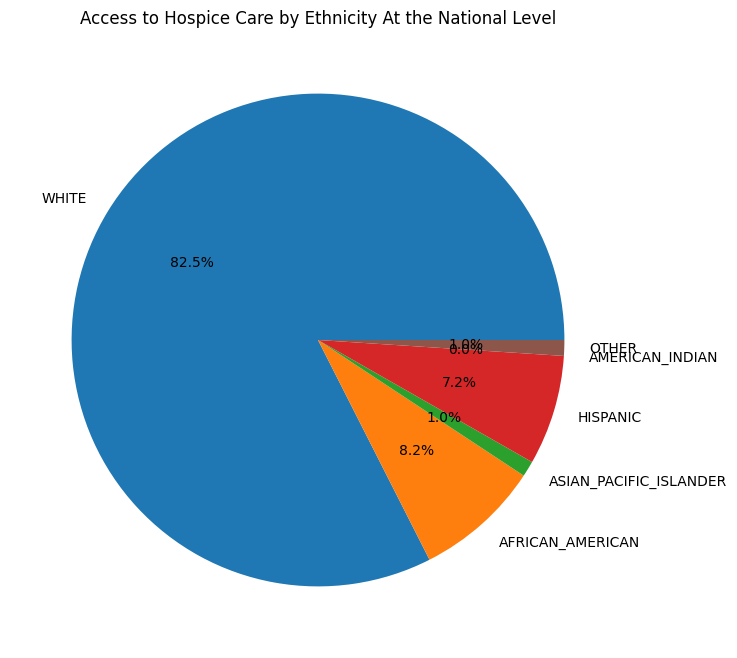

In [99]:
hos_ethn = pd.read_sql_query("SELECT ROUND(BENE_RACE_WHT_PCT*100,2) AS WHITE, ROUND(BENE_RACE_BLACK_PCT*100,2) AS AFRICAN_AMERICAN, ROUND(BENE_RACE_API_PCT*100,2) AS ASIAN_PACIFIC_ISLANDER, ROUND(BENE_RACE_HSPNC_PCT*100,2) AS HISPANIC, ROUND(BENE_RACE_NATIND_PCT*100,2) AS AMERICAN_INDIAN, ROUND(BENE_RACE_OTHR_PCT*100,2) AS OTHER FROM MD_PAC_HOS_2020 WHERE STATE = 'NATIONAL TOTAL'" , conn)
hos_ethn = pd.DataFrame(hos_ethn)
hos_ethn = hos_ethn.T
hos_ethn.columns=['Percent']
hos_ethn = hos_ethn.assign(Race=['WHITE', 'AFRICAN_AMERICAN', 'ASIAN_PACIFIC_ISLANDER','HISPANIC','AMERICAN_INDIAN','OTHER'])
hos_ethn

fig, sc = plt.subplots(figsize=(8, 8))
sc.pie(hos_ethn['Percent'], labels=hos_ethn['Race'], autopct='%.1f%%')
sc.set_title("Access to Hospice Care by Ethnicity At the National Level")
plt.show()

In [100]:
hos_ethn_st = pd.read_sql_query("SELECT STATE, ROUND(BENE_RACE_WHT_PCT*100,2) AS WHITE, ROUND(BENE_RACE_BLACK_PCT*100,2) AS AFRICAN_AMERICAN, ROUND(BENE_RACE_API_PCT*100,2) AS ASIAN_PACIFIC_ISLANDER, ROUND(BENE_RACE_HSPNC_PCT*100,2) AS HISPANIC, ROUND(BENE_RACE_NATIND_PCT*100,2) AS AMERICAN_INDIAN, ROUND(BENE_RACE_OTHR_PCT*100,2) AS OTHER FROM MD_PAC_HOS_2020 WHERE SMRY_CTGRY = 'STATE'" , conn)
hos_ethn_st = pd.DataFrame(hos_ethn_st)
hos_ethn_st.head()


/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



STATE  WHITE  AFRICAN_AMERICAN  ASIAN_PACIFIC_ISLANDER  HISPANIC  \
0    AK   75.0               2.0                     3.0       3.0   
1    AL   80.0              18.0                     0.0       0.0   
2    AR   88.0               8.0                     0.0       0.0   
3    AZ   83.0               2.0                     1.0      10.0   
4    CA   66.0               5.0                     8.0      17.0   

   AMERICAN_INDIAN  OTHER  
0             12.0    2.0  
1              0.0    0.0  
2              0.0    0.0  
3              1.0    0.0  
4              0.0    1.0

/usr/local/lib/python3.10/dist-packages/pandas/io/sql.py:761: UserWarning:

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy



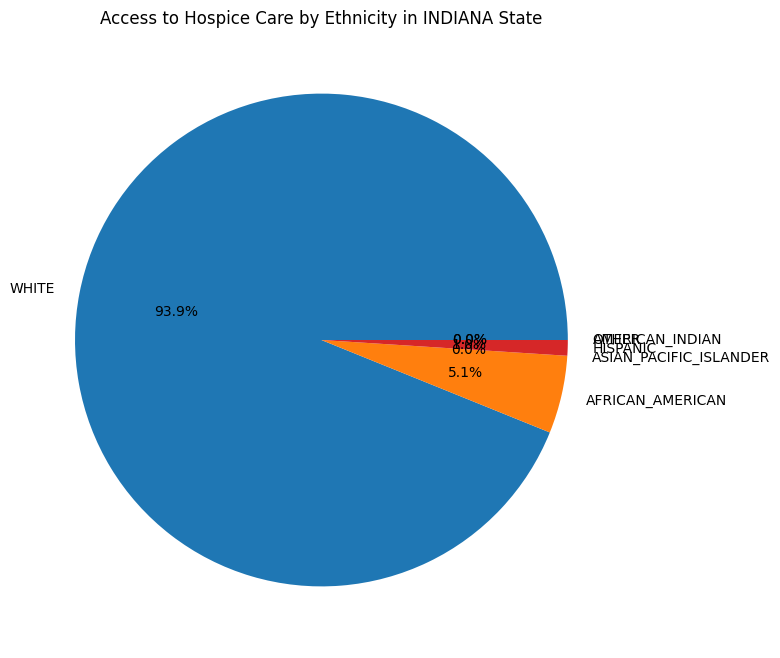

In [101]:
hos_ethnin = pd.read_sql_query("SELECT ROUND(BENE_RACE_WHT_PCT*100,2) AS WHITE, ROUND(BENE_RACE_BLACK_PCT*100,2) AS AFRICAN_AMERICAN, ROUND(BENE_RACE_API_PCT*100,2) AS ASIAN_PACIFIC_ISLANDER, ROUND(BENE_RACE_HSPNC_PCT*100,2) AS HISPANIC, ROUND(BENE_RACE_NATIND_PCT*100,2) AS AMERICAN_INDIAN, ROUND(BENE_RACE_OTHR_PCT*100,2) AS OTHER FROM MD_PAC_HOS_2020 WHERE STATE = 'IN' and SMRY_CTGRY =  'STATE'" , conn)
hos_ethnin = pd.DataFrame(hos_ethnin)
hos_ethnin
hos_ethnin = hos_ethnin.T
hos_ethnin.columns=['Percent']
hos_ethnin = hos_ethnin.assign(Race=['WHITE', 'AFRICAN_AMERICAN', 'ASIAN_PACIFIC_ISLANDER','HISPANIC','AMERICAN_INDIAN','OTHER'])
hos_ethnin

fig, sc = plt.subplots(figsize=(8, 8))
sc.pie(hos_ethnin['Percent'], labels=hos_ethnin['Race'], autopct='%.1f%%')
sc.set_title("Access to Hospice Care by Ethnicity in INDIANA State")
plt.show()